<a href="https://colab.research.google.com/github/HaoPhamUIT/federated-learning/blob/main/FL-CICIOT-2023-with-poison/02_1_FL_CICIOT_2023_FedAdam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01-Data_Exploration

In [2]:
%%capture
# %pip install flwr[simulation] torch torchvision matplotlib sklearn openml

In [3]:
!pip install flwr[simulation] torch torchvision matplotlib scikit-learn openml

  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of grpcio-health-checking to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of grpcio-health-checking to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 19.6 MB/s eta 0:00:

In [4]:
import os
import pandas as pd
import numpy as np
import flwr as fl
from tqdm import tqdm
import warnings
#warnings.filterwarnings('ignore')

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from flwr.common import Metrics
from torch.utils.data import DataLoader, random_split

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [5]:
print("flwr", fl.__version__)
print("numpy", np.__version__)
print("torch", torch.__version__)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE}")

flwr 1.20.0
numpy 2.0.2
torch 2.8.0+cu126
Training on cpu


In [6]:
### THIS SECTION NEEDS TO BE SET TO DETERMINE WHICH CONFIGURATION METHOD TO UTILISE

SPLIT_AVAILABLE_METHODS = ['STRATIFIED','LEAVE_ONE_OUT', 'ONE_CLASS', 'HALF_BENIGN' ]
METHOD = 'LEAVE_ONE_OUT'
NUM_OF_STRATIFIED_CLIENTS = 10  # only applies to stratified method
NUM_OF_ROUNDS = 5              # Number of FL rounds


In [7]:
individual_classifier = True
group_classifier = False
binary_classifier = False


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# Load and combine all training data
import os
from tqdm import tqdm

# Define dataset directory (adjust path as needed)
DATASET_DIRECTORY = '/content/drive/MyDrive/Colab Notebooks/data/CICIoT2023/'

# Load all CSV files
df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
df_sets.sort()

# Use 80% for training
training_sets = df_sets[:int(len(df_sets)*.8)]

print(f"Loading {len(training_sets)} training files...")

# First, let's check what columns are actually available in the dataset
sample_df = pd.read_csv(DATASET_DIRECTORY + training_sets[0])
print(f"Available columns in dataset: {list(sample_df.columns)}")
print(f"Dataset shape: {sample_df.shape}")

# Combine all training data with immediate rounding
combined_df = pd.DataFrame()
for file in tqdm(training_sets):
    df_temp = pd.read_csv(DATASET_DIRECTORY + file)

    # Round numbers immediately after loading each file
    print(f"Rounding numbers in {file}...")
    for col in df_temp.columns:
        if col != 'Label' and df_temp[col].dtype in ['float64', 'float32']:
            # Get max value to determine rounding precision
            col_max = df_temp[col].abs().max()

            if col_max > 1000:
                # Large values: round to 2 decimal places
                df_temp[col] = df_temp[col].round(2)
            elif col_max > 1:
                # Medium values: round to 4 decimal places
                df_temp[col] = df_temp[col].round(4)
            else:
                # Small values (0-1): round to 6 decimal places
                df_temp[col] = df_temp[col].round(6)

    combined_df = pd.concat([combined_df, df_temp], ignore_index=True)

print(f"Combined dataset shape: {combined_df.shape}")
print("All numbers have been rounded during loading process")

# Use actual column names from the dataset (excluding the Label column)
X_columns = [col for col in combined_df.columns if col != 'Label']
y_column = 'Label'

print(f"Using {len(X_columns)} feature columns")
print(f"Feature columns: {X_columns[:10]}...")  # Show first 10 columns

# Apply label mapping based on classification type
dict_34_classes = {
    'BENIGN': 0, 'DDOS-RSTFINFLOOD': 1, 'DDOS-PSHACK_FLOOD': 2, 'DDOS-SYN_FLOOD': 3,
    'DDOS-UDP_FLOOD': 4, 'DDOS-TCP_FLOOD': 5, 'DDOS-ICMP_FLOOD': 6, 'DDOS-SYNONYMOUSIP_FLOOD': 7,
    'DDOS-ACK_FRAGMENTATION': 8, 'DDOS-UDP_FRAGMENTATION': 9, 'DDOS-ICMP_FRAGMENTATION': 10,
    'DDOS-SLOWLORIS': 11, 'DDOS-HTTP_FLOOD': 12, 'DOS-UDP_FLOOD': 13, 'DOS-SYN_FLOOD': 14,
    'DOS-TCP_FLOOD': 15, 'DOS-HTTP_FLOOD': 16, 'MIRAI-GREETH_FLOOD': 17, 'MIRAI-GREIP_FLOOD': 18,
    'MIRAI-UDPPLAIN': 19, 'RECON-PINGSWEEP': 20, 'RECON-OSSCAN': 21, 'RECON-PORTSCAN': 22,
    'VULNERABILITYSCAN': 23, 'RECON-HOSTDISCOVERY': 24, 'DNS_SPOOFING': 25, 'MITM-ARPSPOOFING': 26,
    'BROWSERHIJACKING': 27, 'BACKDOOR_MALWARE': 28, 'XSS': 29, 'UPLOADING_ATTACK': 30,
    'SQLINJECTION': 31, 'COMMANDINJECTION': 32, 'DICTIONARYBRUTEFORCE': 33
}

dict_8_classes = {
    0: 0,  # Benign
    1:1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1,  # DDoS
    13: 7, 14: 7, 15: 7, 16: 7,  # DoS
    17: 2, 18: 2, 19: 2,  # Mirai
    20: 3, 21: 3, 22: 3, 23: 3, 24: 3,  # Reconnaissance
    25: 4, 26: 4,  # Spoofing
    27: 5, 28: 5, 29: 5, 30: 5, 31: 5, 32: 5,  # Web
    33: 6  # Brute Force
}

dict_2_classes = {
    0: 0,  # Benign
    1:1, 2:1, 3:1, 4:1, 5:1, 6:1, 7:1, 8:1, 9:1, 10:1, 11:1, 12:1, 13:1, 14:1, 15:1, 16:1,
    17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1,
    27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1  # All attacks as malicious
}

# Apply label mapping
combined_df['Label'] = combined_df['Label'].map(dict_34_classes)

if group_classifier:
    combined_df['Label'] = combined_df['Label'].map(dict_8_classes)
elif binary_classifier:
    combined_df['Label'] = combined_df['Label'].map(dict_2_classes)

# Remove rows with missing labels
combined_df = combined_df.dropna(subset=['Label'])
combined_df['Label'] = combined_df['Label'].astype(int)

print(f"Label distribution:\n{combined_df['Label'].value_counts().sort_index()}")


Loading 4 training files...
Available columns in dataset: ['Header_Length', 'Protocol Type', 'Time_To_Live', 'Rate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IGMP', 'IPv', 'LLC', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Variance', 'Label']
Dataset shape: (712311, 40)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
  0%|          | 0/4 [00:00<?, ?it/s]

Rounding numbers in Merged01.csv...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
 25%|██▌       | 1/4 [00:03<00:09,  3.31s/it]

Rounding numbers in Merged02.csv...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
 50%|█████     | 2/4 [00:11<00:11,  5.96s/it]

Rounding numbers in Merged03.csv...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
 75%|███████▌  | 3/4 [00:16<00:05,  5.79s/it]

Rounding numbers in Merged04.csv...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
100%|██████████| 4/4 [00:22<00:00,  5.71s/it]
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Combined dataset shape: (2834805, 40)
All numbers have been rounded during loading process
Using 39 feature columns
Feature columns: ['Header_Length', 'Protocol Type', 'Time_To_Live', 'Rate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number']...
Label distribution:
Label
0      66396
1     244023
2     247295
3     245610
4     326263
5     270683
6     432865
7     217410
8      17330
9      17271
10     27248
11      1380
12      1766
13    199952
14    121972
15    160806
16      4426
17     59802
18     45003
19     53710
20       141
21      5795
22      4962
23     22623
24      8165
25     10938
26     18654
27       344
28       180
29       258
30        84
31       323
32       313
33       814
Name: count, dtype: int64


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# Training data

In [10]:
# Check to see if the file 'training_data.pkl' exists in the directory. If it does, load it. If not, print an error.
if os.path.isfile('training_data.pkl'):
    print("File exists, loading data...")
    train_df = pd.read_pickle('training_data.pkl')
    print("Training data loaded from pickle file.")

else:
    df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
    df_sets.sort()
    training_sets = df_sets[:int(len(df_sets)*.8)]
    test_sets = df_sets[int(len(df_sets)*.8):]

    # Print the number of files in each set
    print('Training sets: {}'.format(len(training_sets)))
    print('Test sets: {}'.format(len(test_sets)))

    # ######################
    # # TEMP CODE - This would replicate the original authors code with the last CSV
    # # for training data. Uncomment this section to use this code.
    # ######################
    # # Set training_sets to the last entry of training_sets
    # training_sets = training_sets[-33:]
    # print(f"TO REPLICATE ORIGINAL AUTHORS CODE WITH ONE FILE TRAIN - {training_sets}")
    # #####################
    # # END TEMP CODE
    # ######################

    # Concatenate all training sets into one dataframe
    dfs = []
    print("Reading training data...")
    for train_set in tqdm(training_sets):
        df_new = pd.read_csv(DATASET_DIRECTORY + train_set)
        dfs.append(df_new)
    train_df = pd.concat(dfs, ignore_index=True)

    # Complete training data set size
    print("Complete training data size: {}".format(train_df.shape))

    # Map y column to the dict_34_classes values - The pickle file already has this done.
    train_df['Label'] = train_df['Label'].map(dict_34_classes)

    # The training data is the 80% of the CSV files in the dataset. The test data is the remaining 20%.
    # The Ray Federated learning mechanism cannot cope with all of the 80% training data, so we will split
    # the training data using test_train_split. The test data will be ignored as we will use all the data
    # from the train_sets files as our training data to keep parity with the original authors code.
    #
    # By using a subset of the training data split this way, we can have a randomised selection of data
    # from all the training CSV files, stratified by the attack types.

    # Percentage of original training data to use.
    TRAIN_SIZE = 0.99

    print(f"Splitting the data into {TRAIN_SIZE*100}%")

    X_train, X_test, y_train, y_test = train_test_split(train_df[X_columns], train_df[y_column], test_size= (1 - TRAIN_SIZE), random_state=42, stratify=train_df[y_column])

    # Recombine X_train, and y_train into a dataframe
    train_df = pd.concat([X_train, y_train], axis=1)

    # Clean up unused variables

    del X_train, y_train, X_test, y_test

    # Save the output to a pickle file
    print("Writing training data to pickle file...")
    train_df.to_pickle('training_data.pkl')

print("Training data size: {}".format(train_df.shape))

Training sets: 4
Test sets: 1
Reading training data...


 25%|██▌       | 1/4 [00:02<00:08,  2.87s/it]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
 50%|█████     | 2/4 [00:05<00:05,  2.94s/it]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
 75%|███████▌  | 3/4 [00:08<00:02,  2.84s/it]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent date

Complete training data size: (2834805, 40)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Splitting the data into 99.0%


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Writing training data to pickle file...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Training data size: (2806456, 40)


In [11]:
# show the unique values counts in the label column for train_df
print("Counts of attacks in train_df:")
print(train_df['Label'].value_counts())

Counts of attacks in train_df:
Label
6     428536
4     323000
5     267976
2     244822
3     243154
1     241583
7     215236
13    197952
15    159198
14    120752
0      65732
17     59204
19     53173
18     44553
10     26976
23     22397
26     18467
8      17157
9      17098
25     10829
24      8083
21      5737
22      4912
16      4382
12      1748
11      1366
33       806
27       341
31       320
32       310
29       255
28       178
20       140
30        83
Name: count, dtype: int64


In [12]:
train_df

,Header_Length,Protocol Type,Time_To_Live,Rate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,...,Tot sum,Min,Max,AVG,Std,Tot size,IAT,Number,Variance,Label
106878,20.00,6,64.00,66313.106719,0.00,1.0,0.00,0.0,0.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000065,100,0.000000,7
1146355,20.00,6,64.00,26442.466272,0.00,1.0,0.00,0.0,0.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000038,100,0.000000,3
1166244,8.00,17,64.00,6952.614915,0.00,0.0,0.00,0.0,0.0,0.0,...,55400,554,554,554.00,0.000000,554.00,0.000160,100,0.000000,19
2670446,20.00,6,64.00,34433.166407,0.00,1.0,0.00,0.0,0.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000029,100,0.000000,3
380158,7.20,17,83.10,8807.492335,0.00,0.0,0.00,0.0,0.0,0.0,...,6100,60,70,61.00,3.015113,61.00,0.000114,100,9.090909,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1443499,19.68,6,62.76,15858.081591,0.98,0.0,0.98,0.0,0.0,0.0,...,6303,60,363,63.03,30.300000,63.03,0.000064,100,918.090000,1
1029352,0.00,1,64.00,32564.472050,0.00,0.0,0.00,0.0,0.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000031,100,0.000000,6
323791,20.00,6,64.00,48663.464439,0.00,0.0,0.00,0.0,0.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000021,100,0.000000,5
354404,20.00,6,64.00,17346.170389,0.00,0.0,0.00,1.0,1.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000058,100,0.000000,2


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# Test Data

In [13]:
# Check to see if the file 'test_data.pkl' exists in the directory. If it does, load it. If not, print an error.
testing_data_pickle_file = 'testing_data.pkl'

if os.path.isfile(testing_data_pickle_file):
    print(f"File {testing_data_pickle_file} exists, loading data...")
    test_df = pd.read_pickle(testing_data_pickle_file)
    print("Test data loaded from pickle file.")

else:
    print(f"File {testing_data_pickle_file} does not exist, constructing data...")

    df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
    df_sets.sort()
    training_sets = df_sets[:int(len(df_sets)*.8)]
    test_sets = df_sets[int(len(df_sets)*.8):]

    # Print the number of files in each set
    print('Test sets: {}'.format(len(test_sets)))

    # Concatenate all testing sets into one dataframe
    dfs = []
    print("Reading test data...")
    for test_set in tqdm(test_sets):
        df_new = pd.read_csv(DATASET_DIRECTORY + test_set)
        dfs.append(df_new)
    test_df = pd.concat(dfs, ignore_index=True)

    # Map y column to the dict_34_classes values - The pickle file already has this done.
    test_df['Label'] = test_df['Label'].map(dict_34_classes)

    # Save the output to a pickle file
    print(f"Writing test data to pickle file {testing_data_pickle_file}...")
    test_df.to_pickle(testing_data_pickle_file)

print("Testing data size: {}".format(test_df.shape))

File testing_data.pkl does not exist, constructing data...
Test sets: 1
Reading test data...


100%|██████████| 1/1 [00:05<00:00,  5.41s/it]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
100%|██████████| 1/1 [00:05<00:00,  5.41s/it]
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Writing test data to pickle file testing_data.pkl...
Testing data size: (744804, 40)


In [14]:
print("Number of rows in train_df: {}".format(len(train_df)))
print("Number of rows in test_df: {}".format(len(test_df)))

train_size = len(train_df)
test_size = len(test_df)

Number of rows in train_df: 2806456
Number of rows in test_df: 744804



# Scale the test and train data


Scale the training data input features

In [15]:
scaler = StandardScaler()

# Check for and handle infinite values
print("Checking for and handling infinite values...")
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)
print("Infinite values handled and rows with NaN removed.")

train_df[X_columns] = scaler.fit_transform(train_df[X_columns])

Checking for and handling infinite values...
Infinite values handled and rows with NaN removed.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [16]:
# Check for and handle infinite values
print("Checking for and handling infinite values in test data...")
test_df.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df.dropna(inplace=True)
print("Infinite values handled and rows with NaN removed from test data.")

# Fit the scaler on the training data and then transform the test data
#scaler.fit(train_df[X_columns])
test_df[X_columns] = scaler.transform(test_df[X_columns])

Checking for and handling infinite values in test data...
Infinite values handled and rows with NaN removed from test data.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [17]:
class_size_map = {2: "Binary", 8: "Group", 34: "Individual"}

if group_classifier:
    print("Group 8 Class Classifier... - Adjusting labels in test and train dataframes")
    # Map y column to the dict_7_classes values
    test_df['label'] = test_df['label'].map(dict_8_classes)
    train_df['label'] = train_df['label'].map(dict_8_classes)
    class_size = "8"

elif binary_classifier:
    print("Binary 2 Class Classifier... - Adjusting labels in test and train dataframes")
    # Map y column to the dict_2_classes values
    test_df['label'] = test_df['label'].map(dict_2_classes)
    train_df['label'] = train_df['label'].map(dict_2_classes)
    class_size = "2"

else:
    print ("Individual 34 Class classifier... - No adjustments to labels in test and train dataframes")
    class_size = "34"

Individual 34 Class classifier... - No adjustments to labels in test and train dataframes


# Split the Training Data into partitions for the Federated Learning clients depending on the test required

In [18]:
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the colours used for text printing
from enum import Enum
class Colours(Enum):
    RED = "\033[31m"
    YELLOW = "\033[33m"
    NORMAL = "\033[0m"

# Define fl_X_train and fl_y_train
fl_X_train = []
fl_y_train = []

client_df = pd.DataFrame()

# Define the target label column
y_column = 'Label'

# STRATIFIED method: evenly distribute class labels across clients
if METHOD == 'STRATIFIED':
    print(f"{Colours.YELLOW.value}STRATIFIED METHOD{Colours.NORMAL.value} with {class_size} class classifier")
    skf = StratifiedKFold(n_splits=NUM_OF_STRATIFIED_CLIENTS, shuffle=True, random_state=42)
    for _, test_index in skf.split(train_df[X_columns], train_df[y_column]):
        fl_X_train.append(train_df.iloc[test_index][X_columns])
        fl_y_train.append(train_df.iloc[test_index][y_column])

# LEAVE_ONE_OUT: remove one class (or benign) from each client’s dataset
elif METHOD == 'LEAVE_ONE_OUT':
    print(f"{Colours.YELLOW.value}LEAVE_ONE_OUT METHOD{Colours.NORMAL.value} with {class_size} class classifier")

    num_splits = int(class_size) - 1 if (individual_classifier or group_classifier) else 10
    skf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

    for i, (_, test_index) in enumerate(skf.split(train_df[X_columns], train_df[y_column])):
        current_fold_df = train_df.iloc[test_index]
        if binary_classifier:
            # Even-indexed client: exclude attack class 1
            if i % 2 == 0:
                client_df = current_fold_df[current_fold_df[y_column] != 1].copy()
            else:
                client_df = current_fold_df.copy()
        else:
            # Exclude one specific attack class
            client_df = current_fold_df[current_fold_df[y_column] != (i + 1)].copy()

        fl_X_train.append(client_df[X_columns])
        fl_y_train.append(client_df[y_column])

# ONE_CLASS: each client has Benign + 1 attack class only
elif METHOD == 'ONE_CLASS':
    print(f"{Colours.YELLOW.value}ONE_CLASS METHOD{Colours.NORMAL.value} with {class_size} class classifier")

    num_splits = int(class_size) - 1 if (individual_classifier or group_classifier) else 10
    skf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

    for i, (_, test_index) in enumerate(skf.split(train_df[X_columns], train_df[y_column])):
        current_fold_df = train_df.iloc[test_index]
        if binary_classifier:
            # Even-indexed client: only Benign data
            if i % 2 == 0:
                client_df = current_fold_df[current_fold_df[y_column] != 1].copy()
            else:
                client_df = current_fold_df.copy()
        else:
            # Include only Benign and the (i+1)-th attack class
            mask = (current_fold_df[y_column] == 0) | (current_fold_df[y_column] == (i + 1))
            client_df = current_fold_df[mask].copy()

        fl_X_train.append(client_df[X_columns])
        fl_y_train.append(client_df[y_column])

# HALF_BENIGN: alternate clients between only-benign and full-class datasets
elif METHOD == 'HALF_BENIGN':
    print(f"{Colours.YELLOW.value}HALF_BENIGN METHOD{Colours.NORMAL.value} with {class_size} class classifier")

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    for i, (_, test_index) in enumerate(skf.split(train_df[X_columns], train_df[y_column])):
        current_fold_df = train_df.iloc[test_index]
        if i % 2 == 0:
            # Even-indexed clients: only Benign data
            client_df = current_fold_df[current_fold_df[y_column] == 0].copy()
        else:
            # Odd-indexed clients: all data
            client_df = current_fold_df.copy()

        fl_X_train.append(client_df[X_columns])
        fl_y_train.append(client_df[y_column])

# Handle unknown METHOD value
else:
    print(f"{Colours.RED.value}ERROR: Method {METHOD} not recognised{Colours.NORMAL.value}")

# Update the number of clients created


LEAVE_ONE_OUT METHOD with 34 class classifier


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [19]:
# Model Poisoning Attack
print("--- Applying Model Poisoning ---")
num_malicious_clients = 11  # about 33% of 33 clients
malicious_client_ids = list(range(num_malicious_clients))
target_class = 6 # 'DDOS-ICMP_FLOOD' - This is the most frequent class
new_class = 0    # 'BENIGN'
poison_fraction = 1.0 # poison 100% of the target class samples in malicious clients

print(f"Poisoning {num_malicious_clients} clients: {malicious_client_ids}")
print(f"Flipping label from {target_class} to {new_class} for {poison_fraction*100}% of samples of malicious clients.")

for client_id in malicious_client_ids:
    # fl_y_train[client_id] is a pandas Series.
    # We can get the indices of the target class and replace the labels.
    y_train_series = fl_y_train[client_id]
    target_indices = y_train_series[y_train_series == target_class].index

    num_to_poison = int(len(target_indices) * poison_fraction)

    # Randomly select indices to poison
    poison_indices = np.random.choice(target_indices, num_to_poison, replace=False)

    # Flip the labels in the pandas Series
    fl_y_train[client_id].loc[poison_indices] = new_class

    print(f"Client {client_id}: Flipped {len(poison_indices)} labels from class {target_class} to {new_class}.")

print("--- Model Poisoning Applied ---")


--- Applying Model Poisoning ---
Poisoning 11 clients: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Flipping label from 6 to 0 for 100.0% of samples of malicious clients.
Client 0: Flipped 12985 labels from class 6 to 0.
Client 1: Flipped 12985 labels from class 6 to 0.
Client 2: Flipped 12985 labels from class 6 to 0.
Client 3: Flipped 12986 labels from class 6 to 0.
Client 4: Flipped 12986 labels from class 6 to 0.
Client 5: Flipped 0 labels from class 6 to 0.
Client 6: Flipped 12986 labels from class 6 to 0.
Client 7: Flipped 12986 labels from class 6 to 0.
Client 8: Flipped 12986 labels from class 6 to 0.
Client 9: Flipped 12986 labels from class 6 to 0.
Client 10: Flipped 12986 labels from class 6 to 0.
--- Model Poisoning Applied ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [20]:
# Update the number of clients created
NUM_OF_CLIENTS = len(fl_X_train)
# --- Inspect the training data for each client ---
for i in range(NUM_OF_CLIENTS):
    print(f"\n--- Client ID: {i} ---")
    print(f"fl_X_train[{i}].shape: {fl_X_train[i].shape}")
    print(f"fl_y_train[{i}].value_counts():\n{fl_y_train[i].value_counts()}")
    print(f"fl_y_train[{i}].unique(): {fl_y_train[i].unique()}")

# Check if two clients have identical feature data
print(f"\nfl_X_train[0].equals(fl_X_train[1]): {fl_X_train[0].equals(fl_X_train[1])}")


--- Client ID: 0 ---
fl_X_train[0].shape: (77723, 39)
fl_y_train[0].value_counts():
Label
0     14977
4      9788
5      8121
2      7419
3      7368
7      6523
13     5998
15     4825
14     3659
17     1794
19     1611
18     1350
10      818
23      678
26      560
8       519
9       518
25      328
24      245
21      174
22      148
16      133
12       53
11       41
33       25
27       11
31        9
32        9
29        8
20        5
28        5
30        3
Name: count, dtype: int64
fl_y_train[0].unique(): [ 4  0 13 18 25 19 24  2  5  7 14 15  3 17 10 23 11  8 33 26 22 12 21  9
 16 27 30 29 28 20 31 32]

--- Client ID: 1 ---
fl_X_train[1].shape: (77624, 39)
fl_y_train[1].value_counts():
Label
0     14977
4      9788
5      8121
3      7368
1      7320
7      6523
13     5998
15     4825
14     3659
17     1794
19     1611
18     1350
10      818
23      678
26      560
8       519
9       518
25      328
24      245
21      174
22      148
16      133
12       53
11       

Visualize Data Distribution

STRATIFIED Client

In [21]:
#STRATIFIED Client

In [22]:
#LEAVE_ONE_OUT

In [23]:
#Half begign

In [24]:
#One class

/tmp/ipython-input-3333892375.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors1 = plt.cm.get_cmap('tab20', 20)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


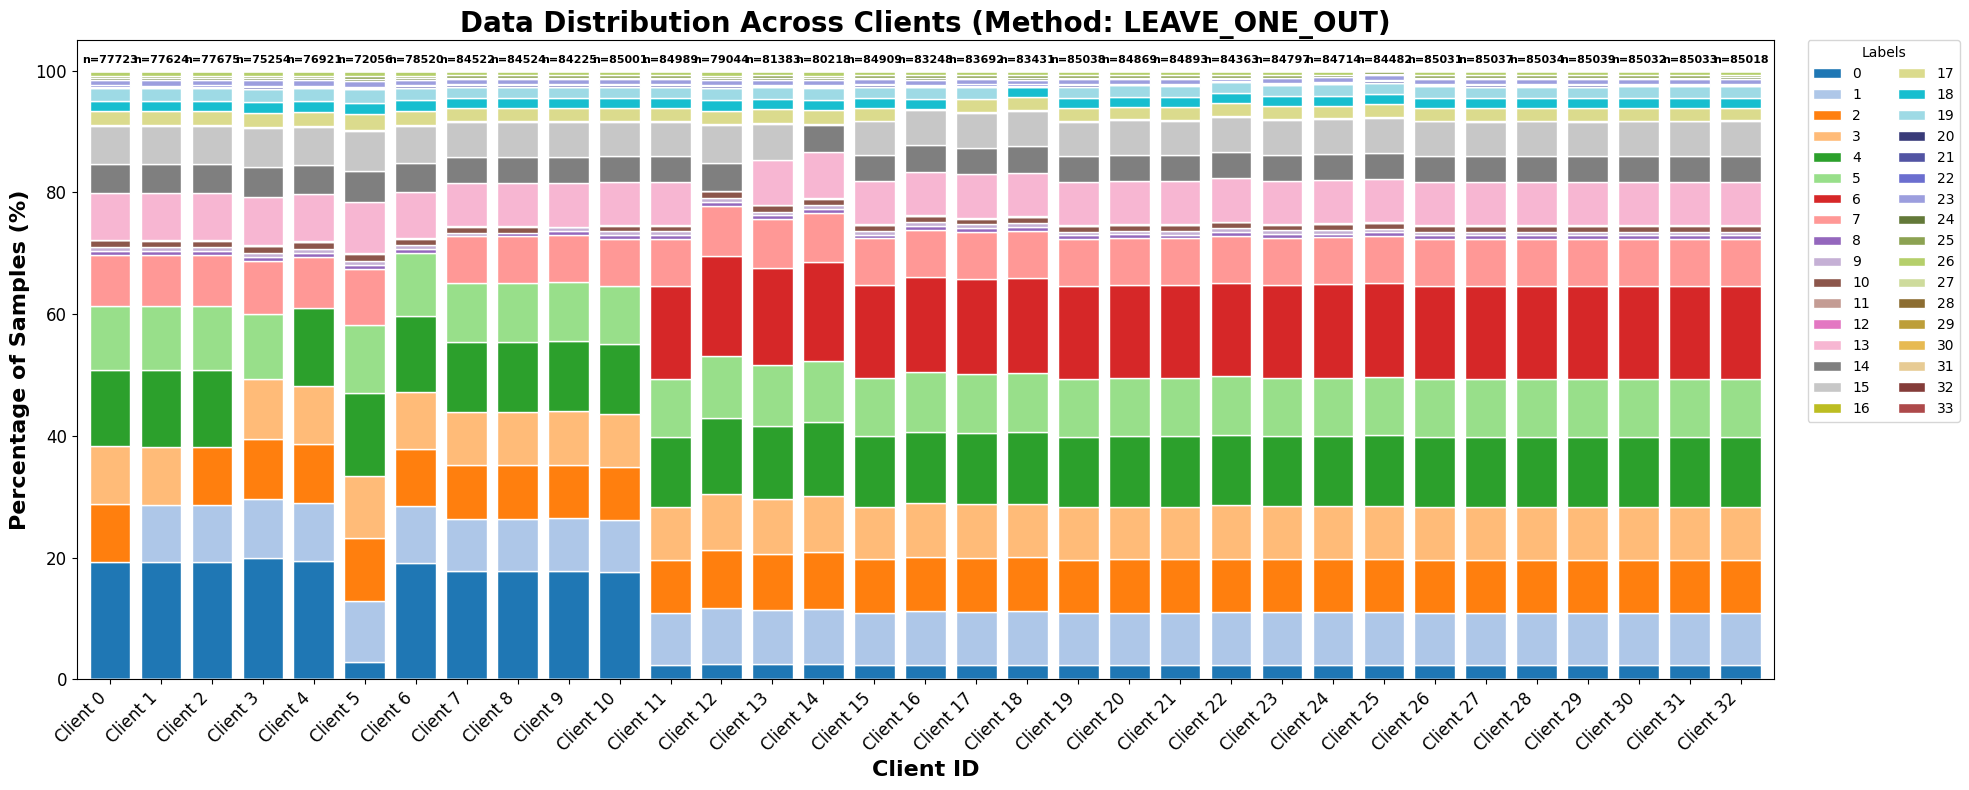

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [25]:
client_distributions = {}
for i in range(NUM_OF_CLIENTS):
    # .value_counts() returns a Series, convert it to a dictionary
    client_distributions[f'Client {i}'] = fl_y_train[i].value_counts().to_dict()

# 2. Convert the dictionary to a Pandas DataFrame for easy manipulation
df_dist = pd.DataFrame(client_distributions).fillna(0).astype(int)
df_dist = df_dist.sort_index() # Sort the labels numerically for consistent colors

# 3. Plot a Stacked Bar Chart
# Convert absolute counts to percentages for the chart y-axis
df_percent = df_dist.divide(df_dist.sum(axis=0), axis=1) * 100

# Create a diverse color palette to ensure distinct colors for all 34 labels
# We combine multiple colormaps to get enough unique colors
colors1 = plt.cm.get_cmap('tab20', 20)
colors2 = plt.cm.get_cmap('tab20b', 20)
colors = np.vstack((colors1.colors, colors2.colors))

# Plot the chart with a much wider figure size
ax = df_percent.T.plot(
    kind='bar',
    stacked=True,
    figsize=(22, 8), # Increased width for readability
    color=colors,
    width=0.8,
    edgecolor="white"
)

# 4. Customize the plot for better presentation
plt.title(f'Data Distribution Across Clients (Method: {METHOD})', fontsize=20, fontweight='bold')
plt.xlabel('Client ID', fontsize=16, fontweight='bold')
plt.ylabel('Percentage of Samples (%)', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=12) # Rotate labels for better fit
plt.yticks(fontsize=12)
plt.ylim(0, 105) # Add a little space at the top for annotations

# Move the legend outside the plot and arrange it in 2 columns
plt.legend(
    title='Labels',
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0.,
    fontsize='medium',
    ncol=2 # Arrange legend in two columns
)

# Adjust layout to prevent the legend from being cut off
plt.tight_layout(rect=[0, 0, 0.9, 1])

# Add total sample count (n=...) above each bar for context
for i, total in enumerate(df_dist.sum(axis=0)):
    ax.text(i, 101, f'n={total}', ha='center', va='bottom', fontsize=8, fontweight='bold')

#  plt.show()

Prepare an output directory where we can store the results of the federated learning

In [26]:
# Create an "Output" directory if it doesnt exist already
if not os.path.exists("Output"):
    os.makedirs("Output")

sub_dir_name = f"train_size-{train_size}"

# if sub_dir_name does not exist, create it
if not os.path.exists(f"Output/{sub_dir_name}"):
    os.makedirs(f"Output/{sub_dir_name}")

test_directory_name = f"{METHOD}_Classifier-{class_size}_Clients-{NUM_OF_CLIENTS}"
output_path = f"Output/{sub_dir_name}/{test_directory_name}" # Lưu lại đường dẫn để dùng sau

# Create an "Output/{METHOD}-{NUM_OF_CLIENTS}-{NUM_OF_ROUNDS}" directory if it doesnt exist already
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Ensure the directory is empty
for file in os.listdir(output_path):
    file_path = os.path.join(output_path, file)
    if os.path.isfile(file_path):
        os.unlink(file_path)

# Original training size is the sum of all the fl_X_train sizes
original_training_size = 0
for i in range(len(fl_X_train)):
    original_training_size += fl_X_train[i].shape[0]

# Write this same info to the output directory/Class Split Info.txt
with open(f"{output_path}/Class Split Info.txt", "w") as f:
    for i in range(len(fl_X_train)):
        f.write(f"Client ID: {i}\n")
        f.write(f"fl_X_train.shape: {fl_X_train[i].shape}\n")
        f.write(f"Training data used {original_training_size}\n")
        f.write(f"fl_y_train.value_counts():\n{fl_y_train[i].value_counts().to_string()}\n")
        f.write(f"fl_y_train.unique(): {fl_y_train[i].unique()}\n\n")

print(f"Output directory and summary file created at: {output_path}")

Output directory and summary file created at: Output/train_size-2806456/LEAVE_ONE_OUT_Classifier-34_Clients-33


Convert the training dataset


In [27]:
# Convert the testing dataframe to numpy arrays for TensorFlow/Keras
X_test = test_df[X_columns].to_numpy()
y_test = test_df[y_column].to_numpy()

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [28]:
# Determine the number of unique classes in the target column
num_unique_classes = len(train_df[y_column].unique())

# Store the shapes of the original dataframes for logging purposes before deleting them
train_df_shape = train_df.shape
test_df_shape = test_df.shape

# Now that we have fl_X_train, fl_y_train, X_test, and y_test extracted,
# we can safely delete the large dataframes to free up memory
if 'train_df' in locals():
    del train_df
if 'test_df' in locals():
    del test_df
if 'client_df' in locals():
    del client_df
print("Final data conversion to numpy complete. Dataframes deleted to free up memory.")

Final data conversion to numpy complete. Dataframes deleted to free up memory.


Data check

In [29]:
print("NUM_CLIENTS:", NUM_OF_CLIENTS)

print("NUM_ROUNDS:", NUM_OF_ROUNDS)
print()


print("Original training size: {}".format(original_training_size))


print("Checking training data split groups")
for i in range(len(fl_X_train)):
    print(i, ":", "X Shape", fl_X_train[i].shape, "Y Shape", fl_y_train[i].shape)


# Print the sizes of X_test and y_test
print("\nChecking testing data")
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

print("\nDeploy Simulation")

NUM_CLIENTS: 33
NUM_ROUNDS: 5

Original training size: 2723339
Checking training data split groups
0 : X Shape (77723, 39) Y Shape (77723,)
1 : X Shape (77624, 39) Y Shape (77624,)
2 : X Shape (77675, 39) Y Shape (77675,)
3 : X Shape (75254, 39) Y Shape (75254,)
4 : X Shape (76921, 39) Y Shape (76921,)
5 : X Shape (72056, 39) Y Shape (72056,)
6 : X Shape (78520, 39) Y Shape (78520,)
7 : X Shape (84522, 39) Y Shape (84522,)
8 : X Shape (84524, 39) Y Shape (84524,)
9 : X Shape (84225, 39) Y Shape (84225,)
10 : X Shape (85001, 39) Y Shape (85001,)
11 : X Shape (84989, 39) Y Shape (84989,)
12 : X Shape (79044, 39) Y Shape (79044,)
13 : X Shape (81383, 39) Y Shape (81383,)
14 : X Shape (80218, 39) Y Shape (80218,)
15 : X Shape (84909, 39) Y Shape (84909,)
16 : X Shape (83248, 39) Y Shape (83248,)
17 : X Shape (83692, 39) Y Shape (83692,)
18 : X Shape (83431, 39) Y Shape (83431,)
19 : X Shape (85038, 39) Y Shape (85038,)
20 : X Shape (84869, 39) Y Shape (84869,)
21 : X Shape (84893, 39) Y Sh

In [30]:
print("X_test min/max/mean:", np.min(X_test), np.max(X_test), np.mean(X_test))
print("Client 0 X min/max/mean:", np.min(fl_X_train[0]), np.max(fl_X_train[0]), np.mean(fl_X_train[0]))

X_test min/max/mean: -52.92539879493338 476.80242930958366 -0.000634890663062242
Client 0 X min/max/mean: -52.92539879493338 136.22155747982657 -0.02330975502083858


#Federated Learning

Import the libraries and print the versions


In [31]:
import os
import flwr as fl
import numpy as np
import tensorflow as tf

# Make TensorFlow log less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout


Define the Client and Server code

In [32]:
import os
import flwr as fl
import numpy as np
import tensorflow as tf

print('scikit-learn {}.'.format(sklearn.__version__))
print("flwr", fl.__version__)
print("numpy", np.__version__)
print("tf", tf.__version__)
# Make TensorFlow log less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout

import datetime

client_evaluations = []

class NumpyFlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, model, train_data, train_labels):
        self.model = model
        self.cid = cid
        self.train_data = train_data
        self.train_labels = train_labels

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        print ("Client ", self.cid, "Training...")
        self.model.fit(self.train_data, self.train_labels, epochs=5, batch_size=32)
        print ("Client ", self.cid, "Training complete...")
        return self.model.get_weights(), len(self.train_data), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        print ("Client ", self.cid, "Evaluating...")
        loss, accuracy = self.model.evaluate(self.train_data, self.train_labels, batch_size=32)
        print(f"{Colours.YELLOW.value}Client {self.cid} evaluation complete - Accuracy: {accuracy:.6f}, Loss: {loss:.6f}{Colours.NORMAL.value}")

        # Write the same message to the "Output/{cid}_Evaluation.txt" file
        with open(f"Output/{sub_dir_name}/{test_directory_name}/{self.cid}_Evaluation.txt", "a") as f:
            f.write(f"{datetime.datetime.now()} - Client {self.cid} evaluation complete - Accuracy: {accuracy:.6f}, Loss: {loss:.6f}\n")

            # Close the file
            f.close()

        return loss, len(self.train_data), {"accuracy": accuracy}

    def predict(self, incoming):
        prediction = np.argmax( self.model.predict(incoming) ,axis=1)
        return prediction

def client_fn(cid: str) -> NumpyFlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    #model = tf.keras.applications.MobileNetV2((32, 32, 3), classes=10, weights=None)
    #model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])

    print ("Client ID:", cid)

    model = Sequential([
      #Flatten(input_shape=(79,1)),
      Dense(50, activation='relu', input_shape=(fl_X_train[0].shape[1],)),
      Dense(25, activation='relu'),
      Dense(num_unique_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


    partition_id = int(cid)
    X_train_c = fl_X_train[partition_id]
    y_train_c = fl_y_train[partition_id]

    # Create a  single Flower client representing a single organization
    return NumpyFlowerClient(cid, model, X_train_c, y_train_c)


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
eval_count = 0

def get_evaluate_fn(server_model):
    global eval_count

    def evaluate(server_round, parameters, config):
        global eval_count

        # Update model weights from the latest client parameters
        server_model.set_weights(parameters)
        print(f"Server Evaluating... Evaluation Count: {eval_count}")

        # Evaluate the model on the test set
        loss, accuracy = server_model.evaluate(X_test, y_test)

        # Record accuracy and loss for visualization or tracking
        server_accuracy_history.append(accuracy)
        server_loss_history.append(loss)

        # Make predictions and save them to a file
        y_pred = server_model.predict(X_test)
        print("Prediction: ", y_pred, y_pred.shape)
        np.save("y_pred-" + str(eval_count) + ".npy", y_pred)

        # Print evaluation result to console
        print(f"{Colours.YELLOW.value}Server evaluation complete - Accuracy: {accuracy:.4f}, Loss: {loss:.4f}{Colours.NORMAL.value}")

        # Write evaluation log to file
        with open(f"Output/{sub_dir_name}/{test_directory_name}/Server_Evaluation.txt", "a") as f:
            f.write(f"{datetime.datetime.now()} - {server_round} : Server evaluation complete - Accuracy: {accuracy:.4f}, Loss: {loss:.4f}\n")

        # Increment evaluation counter
        eval_count += 1

        return loss, {"accuracy": accuracy}

    return evaluate



scikit-learn 1.6.1.
flwr 1.20.0
numpy 2.0.2
tf 2.19.0


Initialize Server Model and Strategy

In [34]:
from flwr.common import ndarrays_to_parameters
server_model = Sequential([
    #Flatten(input_shape=(79,1)),
    Flatten(input_shape=(fl_X_train[0].shape[1] , 1)),
    Dense(50, activation='relu'),
    Dense(25, activation='relu'),
    Dense(num_unique_classes, activation='softmax')
])


server_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

initial_weights = server_model.get_weights()
initial_parameters = ndarrays_to_parameters(initial_weights)
# Create FedAvg strategy
# strategy = fl.server.strategy.FedAvg(
#         fraction_fit=1.0,
#         fraction_evaluate=0.5,
#         min_fit_clients=10, #10,
#         min_evaluate_clients=5, #5,
#         min_available_clients=10, #10,
#         evaluate_fn=get_evaluate_fn(server_model),
#         #evaluate_metrics_aggregation_fn=weighted_average,
# )
# Test FedAdam


strategy = fl.server.strategy.FedAdam(
        fraction_fit=1.0,
        fraction_evaluate=0.5,
        min_fit_clients=10,
        min_evaluate_clients=5,
        min_available_clients=10,
        evaluate_fn=get_evaluate_fn(server_model),
        eta=1.0,           # Server-side learning rate
        beta_1=0.9,
        beta_2=0.999,
        tau=1e-9,
        initial_parameters=initial_parameters
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Deploy Simulation

	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=5, no round_timeout



Deploy simulation... Method = LEAVE_ONE_OUT - Individual (34) Classifier
Number of Clients = 33

Writing output to: train_size-2806456/LEAVE_ONE_OUT_Classifier-34_Clients-33



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
2025-09-04 11:41:20,080	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'object_store_memory': 4003091251.0, 'node:172.28.0.12': 1.0, 'memory': 8006182503.0, 'node:__internal_head__': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters


Server Evaluating... Evaluation Count: 0
 1314/23275 ━━━━━━━━━━━━━━━━━━━━ 56s 3ms/step - accuracy: 0.0030 - loss: 3.6100

(pid=1744) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=1744) E0000 00:00:1756986086.984350    1744 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=1744) E0000 00:00:1756986086.998807    1744 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=1744) W0000 00:00:1756986087.099010    1744 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
(pid=1744) W0000 00:00:1756986087.099106    1744 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
(pid=1744) W0000 00:00:1756986087.099113    1744 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking t

23275/23275 ━━━━━━━━━━━━━━━━━━━━ 68s 3ms/step - accuracy: 0.0030 - loss: 3.6090
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 32s 1ms/step


INFO :      initial parameters (loss, other metrics): 3.6096692085266113, {'accuracy': 0.003105573356151581}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 33 clients (out of 33)


Prediction:  [[0.03543201 0.03146248 0.03279558 ... 0.03150024 0.01947117 0.0240781 ]
 [0.04017741 0.04672812 0.02297512 ... 0.02421382 0.01683968 0.02100296]
 [0.03435214 0.02987197 0.0352899  ... 0.03383712 0.02515347 0.02376984]
 ...
 [0.03952735 0.0283999  0.02918589 ... 0.02209835 0.01570578 0.01778265]
 [0.02781205 0.03419565 0.03134749 ... 0.02700615 0.03062815 0.02827434]
 [0.02965379 0.0340584  0.03036018 ... 0.02763263 0.02898007 0.02849319]] (744790, 34)
Server evaluation complete - Accuracy: 0.0031, Loss: 3.6097


(ClientAppActor pid=1745) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1745) 
(ClientAppActor pid=1745)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1745)             entirely in future versions of Flower.
(ClientAppActor pid=1745)         
(ClientAppActor pid=1745) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1745)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(pid=1745) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=1745) E0000 0

(ClientAppActor pid=1745) Client ID: 7
(ClientAppActor pid=1745) Client  7 Training...


(ClientAppActor pid=1744) 
(ClientAppActor pid=1744)         


(ClientAppActor pid=1745) Epoch 1/5
   1/2642 ━━━━━━━━━━━━━━━━━━━━ 1:17:30 2s/step - accuracy: 0.0000e+00 - loss: 3.4211
  16/2404 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.1035 - loss: 3.3920    
  31/2642 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.1400 - loss: 3.2633 
  47/2404 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.2294 - loss: 3.1812
 552/2642 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5613 - loss: 1.6070
(ClientAppActor pid=1744) Client ID: 4
(ClientAppActor pid=1744) Client  4 Training...
(ClientAppActor pid=1744) Epoch 1/5
1064/2404 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6466 - loss: 1.2114
1464/2404 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6702 - loss: 1.0694
1492/2404 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6715 - loss: 1.0617
1574/2404 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6750 - loss: 1.0405 [repeated 91x across cluster]
1531/2404 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6732 - loss: 1.0514
1760/2642 ━━━━━━━━━━━━━━━━━━

(ClientAppActor pid=1744) 
(ClientAppActor pid=1744)         
(ClientAppActor pid=1744) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=1744)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=1744)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=1744) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 2x across cluster]
(ClientAppActor pid=1744)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) 

(ClientAppActor pid=1744) Client ID: 12
(ClientAppActor pid=1744) Client  12 Training...
(ClientAppActor pid=1744) Epoch 1/5
1137/2642 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7469 - loss: 0.4917 [repeated 2x across cluster]
1664/2642 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7469 - loss: 0.4914 [repeated 71x across cluster]
   1/2471 ━━━━━━━━━━━━━━━━━━━━ 1:17:05 2s/step - accuracy: 0.0000e+00 - loss: 3.4881
  36/2471 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.1178 - loss: 3.3466
(ClientAppActor pid=1745) Client  7 Training complete...
 754/2471 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6322 - loss: 1.4224 [repeated 2x across cluster]
(ClientAppActor pid=1745) Client ID: 9
(ClientAppActor pid=1745) Client  9 Training...


(ClientAppActor pid=1745) 
(ClientAppActor pid=1745)         
(ClientAppActor pid=1745) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1745)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1745)             entirely in future versions of Flower.
(ClientAppActor pid=1745) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1745)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1745) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

 824/2471 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6401 - loss: 1.3697 [repeated 81x across cluster]
(ClientAppActor pid=1745) Epoch 1/5
  16/2633 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.0886 - loss: 3.5790        
 146/2633 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.3831 - loss: 2.6681
 184/2633 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.4187 - loss: 2.4845 [repeated 5x across cluster]
1937/2471 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6997 - loss: 0.9700 [repeated 56x across cluster]
 626/2633 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5724 - loss: 1.5693
(ClientAppActor pid=1744) Epoch 2/5
   1/2471 ━━━━━━━━━━━━━━━━━━━━ 1:56 47ms/step - accuracy: 0.7812 - loss: 0.3506
  33/2471 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7843 - loss: 0.4168
 775/2471 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7772 - loss: 0.4448 [repeated 5x across cluster]
 961/2471 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7769 - loss: 0.4451 [repeated 92x across cluster]

(ClientAppActor pid=1744) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1744) 
(ClientAppActor pid=1744)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1744)             entirely in future versions of Flower.
(ClientAppActor pid=1744)         
(ClientAppActor pid=1744) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1744)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1744) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=1744) Client  8 Training...
  84/2633 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.7563 - loss: 0.4871
 109/2633 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.7532 - loss: 0.4914
 129/2633 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.7518 - loss: 0.4929
 148/2633 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.7512 - loss: 0.4934
 169/2633 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.7510 - loss: 0.4932
 188/2633 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.7510 - loss: 0.4928
 210/2633 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.7513 - loss: 0.4922
 224/2633 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.7514 - loss: 0.4919
 244/2633 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.7513 - loss: 0.4916
 267/2633 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.7511 - loss: 0.4914
 285/2633 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.7510 - loss: 0.4913
 293/2633 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.7509 - loss: 0.4912
 315/2633 ━━━━━━

(ClientAppActor pid=1745) 
(ClientAppActor pid=1745)         
(ClientAppActor pid=1745) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1745)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1745)             entirely in future versions of Flower.
(ClientAppActor pid=1745) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1745)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1745) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=1745) Client ID: 10
(ClientAppActor pid=1745) Client  10 Training...
(ClientAppActor pid=1745) Epoch 1/5
  14/2657 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.0968 - loss: 3.3332   
   1/2642 ━━━━━━━━━━━━━━━━━━━━ 1:51 42ms/step - accuracy: 0.6250 - loss: 0.6669
  46/2657 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.2029 - loss: 3.1729
  34/2642 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7013 - loss: 0.5641
 245/2657 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.4527 - loss: 2.1865
 570/2642 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7314 - loss: 0.5211 [repeated 70x across cluster]
 723/2657 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5813 - loss: 1.4427
(ClientAppActor pid=1744) Epoch 2/5
 746/2657 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5843 - loss: 1.4250
 753/2657 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5852 - loss: 1.4197
 998/2657 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6106 - loss: 1.2726 [repeated 2x across cluster]
130

(ClientAppActor pid=1744) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1744) 
(ClientAppActor pid=1744)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1744)             entirely in future versions of Flower.
(ClientAppActor pid=1744)         
(ClientAppActor pid=1744) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1744)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1744) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=1744) Client ID: 29
(ClientAppActor pid=1744) Client  29 Training...
  17/2658 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.0151 - loss: 3.4794        
 105/2658 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.2996 - loss: 2.9976 [repeated 65x across cluster]
2642/2642 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.7481 - loss: 0.4886
 235/2657 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7573 - loss: 0.4780  [repeated 4x across cluster]
(ClientAppActor pid=1744) Epoch 1/5
 842/2658 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6055 - loss: 1.4245
 886/2658 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6098 - loss: 1.3957
 924/2658 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6134 - loss: 1.3723
 931/2658 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6140 - loss: 1.3682
1107/2658 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6276 - loss: 1.2776 [repeated 92x across cluster]
1070/2658 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6250 - loss: 1.2947 [repea

(ClientAppActor pid=1745) 
(ClientAppActor pid=1745)         
(ClientAppActor pid=1745) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=1745) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1745)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1745)             entirely in future versions of Flower.
(ClientAppActor pid=1745) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first lay

(ClientAppActor pid=1745) Client ID: 17
(ClientAppActor pid=1745) Client  17 Training...
(ClientAppActor pid=1745) Epoch 1/5
2262/2658 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6702 - loss: 0.9845 [repeated 85x across cluster]
   1/2616 ━━━━━━━━━━━━━━━━━━━━ 1:16:11 2s/step - accuracy: 0.0000e+00 - loss: 3.5754
  29/2616 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.0416 - loss: 3.4687
  66/2616 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.1841 - loss: 3.2563
  22/2658 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.7257 - loss: 0.4848
  87/2616 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.2463 - loss: 3.1247
 649/2616 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5779 - loss: 1.5750 [repeated 4x across cluster]
(ClientAppActor pid=1744) Epoch 2/5
1108/2658 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7287 - loss: 0.5234 [repeated 73x across cluster]
   1/2658 ━━━━━━━━━━━━━━━━━━━━ 3:10 72ms/step - accuracy: 0.7812 - loss: 0.4196
1520/2616 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step 

(ClientAppActor pid=1744) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1744) 
(ClientAppActor pid=1744)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1744)             entirely in future versions of Flower.
(ClientAppActor pid=1744)         
(ClientAppActor pid=1744) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1744)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1744) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=1744) Client ID: 19
(ClientAppActor pid=1744) Client  19 Training...
(ClientAppActor pid=1744) Epoch 1/5
  16/2658 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.0304 - loss: 3.5889        
 678/2658 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5740 - loss: 1.5832 [repeated 75x across cluster]
(ClientAppActor pid=1745) Client  17 Training complete...


(ClientAppActor pid=1745) 
(ClientAppActor pid=1745)         
(ClientAppActor pid=1745) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1745)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1745)             entirely in future versions of Flower.
(ClientAppActor pid=1745) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1745)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1745) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=1745) Client ID: 3
(ClientAppActor pid=1745) Client  3 Training...
(ClientAppActor pid=1745) Epoch 1/5
2096/2658 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6610 - loss: 1.0252 [repeated 84x across cluster]
2292/2658 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6658 - loss: 0.9942
   1/2352 ━━━━━━━━━━━━━━━━━━━━ 2:17:52 4s/step - accuracy: 0.0625 - loss: 3.4525
  14/2352 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.1293 - loss: 3.3805
  29/2352 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.1806 - loss: 3.2617
  44/2352 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.2261 - loss: 3.1605
  50/2352 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.2419 - loss: 3.1209
  78/2352 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.3082 - loss: 2.9382
2658/2658 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6731 - loss: 0.9464
  90/2352 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.3321 - loss: 2.8630
   8/2658 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.6968 - l

(ClientAppActor pid=1744) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1744) 
(ClientAppActor pid=1744)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1744)             entirely in future versions of Flower.
(ClientAppActor pid=1744)         
(ClientAppActor pid=1744) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1744)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1744) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=1744) Client ID: 15
(ClientAppActor pid=1744) Client  15 Training...
(ClientAppActor pid=1744) Epoch 1/5
   1/2654 ━━━━━━━━━━━━━━━━━━━━ 2:09:32 3s/step - accuracy: 0.0000e+00 - loss: 3.5762
  12/2654 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - accuracy: 0.0114 - loss: 3.5344    
2104/2352 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7712 - loss: 0.4449
  27/2654 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.0418 - loss: 3.4577
  43/2654 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.0998 - loss: 3.3855
  60/2654 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.1649 - loss: 3.2946
  75/2654 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.2124 - loss: 3.2111
2178/2352 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7712 - loss: 0.4450
  90/2654 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.2516 - loss: 3.1220
 103/2654 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.2801 - loss: 3.0430
 108/2654 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.2899 - loss: 3.0127
 124/265

(ClientAppActor pid=1745) 
(ClientAppActor pid=1745)         
(ClientAppActor pid=1745) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1745)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1745)             entirely in future versions of Flower.
(ClientAppActor pid=1745) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1745)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1745) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

 311/2654 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.4773 - loss: 2.1663
(ClientAppActor pid=1745) Client  20 Training...
 324/2654 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.4835 - loss: 2.1323
 340/2654 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.4905 - loss: 2.0926
(ClientAppActor pid=1745) Epoch 1/5
 357/2654 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.4976 - loss: 2.0528
 373/2654 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.5037 - loss: 2.0175
 389/2654 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.5095 - loss: 1.9841
 414/2654 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.5177 - loss: 1.9352
 434/2654 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.5238 - loss: 1.8988
 452/2654 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.5290 - loss: 1.8678
 472/2654 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.5344 - loss: 1.8352
 492/2654 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.5395 - loss: 1.8044
 505/2654 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0

(ClientAppActor pid=1744) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1744) 
(ClientAppActor pid=1744)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1744)             entirely in future versions of Flower.
(ClientAppActor pid=1744)         
(ClientAppActor pid=1744) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1744)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1744) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=1744) Client ID: 31
(ClientAppActor pid=1744) Client  31 Training...
(ClientAppActor pid=1744) Epoch 1/5


(ClientAppActor pid=1745) 
(ClientAppActor pid=1745)         
(ClientAppActor pid=1745) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


   1/2658 ━━━━━━━━━━━━━━━━━━━━ 1:26:37 2s/step - accuracy: 0.0000e+00 - loss: 3.7919
  29/2658 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.0426 - loss: 3.4561 
2654/2654 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.7511 - loss: 0.4839
  35/2658 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.0758 - loss: 3.3920
 642/2658 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5698 - loss: 1.5931
 659/2658 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5726 - loss: 1.5762
(ClientAppActor pid=1745) Client  20 Training complete...
 675/2658 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5751 - loss: 1.5608
 683/2658 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5763 - loss: 1.5533
 710/2658 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5803 - loss: 1.5290 [repeated 42x across cluster]
 169/2658 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.3850 - loss: 2.6478
 184/2658 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.3998 - loss: 2.5777
 201/2658 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accurac

(ClientAppActor pid=1744) 
(ClientAppActor pid=1744)         
(ClientAppActor pid=1744) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=1744)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=1744)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=1744) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 2x across cluster]
(ClientAppActor pid=1744)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) 

(ClientAppActor pid=1744) Client ID: 27
(ClientAppActor pid=1744) Client  27 Training...
(ClientAppActor pid=1744) Epoch 1/5
2631/2658 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7491 - loss: 0.4870 [repeated 81x across cluster]


(ClientAppActor pid=1745) 
(ClientAppActor pid=1745)         
(ClientAppActor pid=1745) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


  16/2658 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.0201 - loss: 3.5020        
2658/2658 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.7491 - loss: 0.4871 [repeated 7x across cluster]
(ClientAppActor pid=1745) Client  26 Training complete...
(ClientAppActor pid=1745) Client ID: 23
(ClientAppActor pid=1745) Client  23 Training...
(ClientAppActor pid=1745) Epoch 1/5
1233/2658 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6337 - loss: 1.2209 [repeated 63x across cluster]
  18/2650 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.0295 - loss: 3.4630        
 890/2658 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6085 - loss: 1.3874
1612/2650 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6503 - loss: 1.0981
1623/2650 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6507 - loss: 1.0954
2295/2658 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6706 - loss: 0.9756 [repeated 93x across cluster]
2273/2650 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6694 - loss: 0.9731 [repeated 4x acros

(ClientAppActor pid=1744) 
(ClientAppActor pid=1744)         
(ClientAppActor pid=1744) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=1744)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=1744)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=1744) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 2x across cluster]
(ClientAppActor pid=1744)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) 

(ClientAppActor pid=1744) Client ID: 11
(ClientAppActor pid=1744) Client  11 Training...
(ClientAppActor pid=1744) Epoch 1/5
2407/2650 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7458 - loss: 0.4827 [repeated 82x across cluster]
2534/2650 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7459 - loss: 0.4826


(ClientAppActor pid=1745) 
(ClientAppActor pid=1745)         


   1/2656 ━━━━━━━━━━━━━━━━━━━━ 2:47:55 4s/step - accuracy: 0.0000e+00 - loss: 3.5115
  14/2656 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.0225 - loss: 3.4867
  27/2656 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.0473 - loss: 3.4230
  49/2656 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.1256 - loss: 3.3062
  71/2656 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.2005 - loss: 3.1787
  86/2656 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.2415 - loss: 3.0867
(ClientAppActor pid=1745) Client  23 Training complete...
 103/2656 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.2790 - loss: 2.9835
2650/2650 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7460 - loss: 0.4825 [repeated 5x across cluster]
 122/2656 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.3129 - loss: 2.8715
 145/2656 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.3458 - loss: 2.7460
 162/2656 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.3663 - loss: 2.6595
(ClientAppActor pid=1745) Client ID: 22
 179/265

(ClientAppActor pid=1745) 
(ClientAppActor pid=1745)         
(ClientAppActor pid=1745) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=1745)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=1745)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=1745) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 2x across cluster]
(ClientAppActor pid=1745)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) 

(ClientAppActor pid=1745) Client ID: 28
(ClientAppActor pid=1745) Client  28 Training...
(ClientAppActor pid=1745) Epoch 1/5


(ClientAppActor pid=1744) 
(ClientAppActor pid=1744)         


   1/2658 ━━━━━━━━━━━━━━━━━━━━ 1:18:20 2s/step - accuracy: 0.0000e+00 - loss: 3.5874
  36/2658 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.0761 - loss: 3.4040
 219/2658 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.4282 - loss: 2.4420 [repeated 57x across cluster]
  28/2658 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.0420 - loss: 3.4625 
 296/2658 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.4719 - loss: 2.1689
(ClientAppActor pid=1744) Client  11 Training complete...
 535/2658 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5501 - loss: 1.7177
(ClientAppActor pid=1744) Client ID: 30
(ClientAppActor pid=1744) Client  30 Training...
(ClientAppActor pid=1744) Epoch 1/5
   1/2658 ━━━━━━━━━━━━━━━━━━━━ 1:12:40 2s/step - accuracy: 0.0000e+00 - loss: 3.6574
 909/2658 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.6044 - loss: 1.3860 [repeated 91x across cluster]
1240/2658 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6284 - loss: 1.2317
1033/2658 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - ac

(ClientAppActor pid=1745) 
(ClientAppActor pid=1745)         
(ClientAppActor pid=1745) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=1745)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=1745)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=1745) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 2x across cluster]
(ClientAppActor pid=1745)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) 

(ClientAppActor pid=1745) Client ID: 14
(ClientAppActor pid=1745) Client  14 Training...


(ClientAppActor pid=1744) 
(ClientAppActor pid=1744)         


2658/2658 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.7472 - loss: 0.4911 [repeated 6x across cluster]
(ClientAppActor pid=1745) Epoch 1/5
  17/2507 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.0233 - loss: 3.5430        
   1/2641 ━━━━━━━━━━━━━━━━━━━━ 1:13:48 2s/step - accuracy: 0.0000e+00 - loss: 3.6086
  31/2641 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.0709 - loss: 3.4046
 479/2507 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5490 - loss: 1.7457
 592/2641 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5727 - loss: 1.6139 [repeated 48x across cluster]
(ClientAppActor pid=1744) Client  30 Training complete...
(ClientAppActor pid=1744) Client ID: 25
(ClientAppActor pid=1744) Client  25 Training...
 739/2641 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5950 - loss: 1.4742 [repeated 4x across cluster]
(ClientAppActor pid=1744) Epoch 1/5
2050/2641 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6681 - loss: 0.9988 [repeated 96x across cluster]
2212/2641 ━━━━━━━━━━━━━━━━━━━━

(ClientAppActor pid=1745) 
(ClientAppActor pid=1745)         
(ClientAppActor pid=1745) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=1745)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=1745)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=1745) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 2x across cluster]
(ClientAppActor pid=1745)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) 

(ClientAppActor pid=1745) Client ID: 13
(ClientAppActor pid=1745) Client  13 Training...
(ClientAppActor pid=1745) Epoch 1/5
2635/2641 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7484 - loss: 0.4782 [repeated 80x across cluster]


(ClientAppActor pid=1744) 
(ClientAppActor pid=1744)         


   1/2544 ━━━━━━━━━━━━━━━━━━━━ 1:18:32 2s/step - accuracy: 0.0000e+00 - loss: 3.6993
  34/2544 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.0753 - loss: 3.4094
2641/2641 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7484 - loss: 0.4782 [repeated 4x across cluster]
 309/2544 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.4975 - loss: 2.0825
  14/2602 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.0097 - loss: 3.5348
  26/2602 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.0384 - loss: 3.4656
  40/2602 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.0999 - loss: 3.3821
  53/2602 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.1551 - loss: 3.3044
  72/2602 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.2222 - loss: 3.1864
  88/2602 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.2681 - loss: 3.0846
 103/2602 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.3035 - loss: 2.9885
(ClientAppActor pid=1744) Client  25 Training complete...
 116/2602 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accur

(ClientAppActor pid=1745) 
(ClientAppActor pid=1745)         
(ClientAppActor pid=1745) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=1745)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=1745)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=1745) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 2x across cluster]
(ClientAppActor pid=1745)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) 

1663/2602 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7602 - loss: 0.4715 [repeated 7x across cluster]
  14/2426 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.1010 - loss: 3.3705        
  69/2426 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.2979 - loss: 3.0345


(ClientAppActor pid=1744) 
(ClientAppActor pid=1744)         


(ClientAppActor pid=1744) Client  16 Training complete...
 914/2426 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6005 - loss: 1.3534 [repeated 59x across cluster]
(ClientAppActor pid=1744) Client ID: 18
(ClientAppActor pid=1744) Client  18 Training...
   1/2608 ━━━━━━━━━━━━━━━━━━━━ 1:15:30 2s/step - accuracy: 0.0000e+00 - loss: 3.6582
(ClientAppActor pid=1744) Epoch 1/5
  35/2608 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.0817 - loss: 3.4083
2031/2426 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6468 - loss: 1.0296
1292/2608 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6333 - loss: 1.2096 [repeated 94x across cluster]
2287/2426 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6520 - loss: 0.9927
2323/2426 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6527 - loss: 0.9880
2336/2426 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6529 - loss: 0.9864
(ClientAppActor pid=1745) Epoch 2/5
   8/2426 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.7131 - loss: 0.6072   
  24/2426 ━━━━━━

(ClientAppActor pid=1745) 
(ClientAppActor pid=1745)         
(ClientAppActor pid=1745) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=1745)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=1745)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=1745) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 2x across cluster]
(ClientAppActor pid=1745)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) 

(ClientAppActor pid=1745) Client ID: 24
(ClientAppActor pid=1745) Client  24 Training...
  18/2648 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.0177 - loss: 3.5246        
(ClientAppActor pid=1745) Epoch 1/5
1832/2608 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7432 - loss: 0.4967 [repeated 75x across cluster]
 450/2648 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5338 - loss: 1.8220
 498/2648 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5465 - loss: 1.7474
2051/2608 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7433 - loss: 0.4966
2128/2608 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7433 - loss: 0.4966
2155/2608 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7433 - loss: 0.4966
2184/2608 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7433 - loss: 0.4966
(ClientAppActor pid=1744) Client  18 Training complete...
1284/2648 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6360 - loss: 1.1914 [repeated 71x across cluster]
1189/2648 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0

(ClientAppActor pid=1744) 
(ClientAppActor pid=1744)         
(ClientAppActor pid=1744) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1744)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1744)             entirely in future versions of Flower.
(ClientAppActor pid=1744) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1744)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1744) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=1744) Client ID: 5
(ClientAppActor pid=1744) Client  5 Training...
(ClientAppActor pid=1744) Epoch 1/5
1294/2648 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6366 - loss: 1.1879 [repeated 14x across cluster]
   1/2252 ━━━━━━━━━━━━━━━━━━━━ 1:22:10 2s/step - accuracy: 0.0000e+00 - loss: 3.5048
  37/2252 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.0954 - loss: 3.3104
 723/2252 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5476 - loss: 1.5434 [repeated 68x across cluster]
  20/2648 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7834 - loss: 0.4437   
(ClientAppActor pid=1745) Epoch 2/5
2382/2648 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6714 - loss: 0.9546 [repeated 2x across cluster]
1210/2252 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5870 - loss: 1.2843
2244/2252 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6220 - loss: 1.0537 [repeated 90x across cluster]
(ClientAppActor pid=1744) Epoch 2/5
   1/2252 ━━━━━━━━━━━━━━━━━━━━ 1:30 40ms/step - accuracy: 0

(ClientAppActor pid=1744) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1744) 
(ClientAppActor pid=1744)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1744)             entirely in future versions of Flower.
(ClientAppActor pid=1744)         
(ClientAppActor pid=1744) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1744)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1744) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=1744) Client ID: 21
(ClientAppActor pid=1744) Client  21 Training...
(ClientAppActor pid=1744) Epoch 1/5


(ClientAppActor pid=1745) 
(ClientAppActor pid=1745)         


2648/2648 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.7513 - loss: 0.4774 [repeated 83x across cluster]
  15/2653 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.0149 - loss: 3.5083        
2385/2648 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7514 - loss: 0.4774 [repeated 3x across cluster]
   1/2454 ━━━━━━━━━━━━━━━━━━━━ 1:06:50 2s/step - accuracy: 0.0000e+00 - loss: 3.7091
  31/2454 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.1410 - loss: 3.3113
(ClientAppActor pid=1745) Client  24 Training complete...
(ClientAppActor pid=1745) Client ID: 6
(ClientAppActor pid=1745) Client  6 Training...
(ClientAppActor pid=1745) Epoch 1/5
1068/2653 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6248 - loss: 1.3022 [repeated 65x across cluster]
1451/2653 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6451 - loss: 1.1576
1359/2653 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6410 - loss: 1.1865 [repeated 2x across cluster]
2346/2653 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6709 - loss

(ClientAppActor pid=1745) 
(ClientAppActor pid=1745)         
(ClientAppActor pid=1745) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=1745)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=1745)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=1745) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 2x across cluster]
(ClientAppActor pid=1745)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) 

(ClientAppActor pid=1745) Client ID: 2
(ClientAppActor pid=1745) Client  2 Training...
(ClientAppActor pid=1745) Epoch 1/5
  16/2428 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.1167 - loss: 3.3437    
2644/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7466 - loss: 0.4823 [repeated 74x across cluster]


(ClientAppActor pid=1744) 
(ClientAppActor pid=1744)         


 555/2428 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6107 - loss: 1.5198 [repeated 2x across cluster]
(ClientAppActor pid=1744) Client  21 Training complete...
(ClientAppActor pid=1744) Client ID: 32
(ClientAppActor pid=1744) Client  32 Training...
(ClientAppActor pid=1744) Epoch 1/5
  23/2657 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.0261 - loss: 3.4971
  31/2657 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.0472 - loss: 3.4573
  39/2657 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.0770 - loss: 3.4167
  46/2657 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.1063 - loss: 3.3793
  58/2657 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.1539 - loss: 3.3121
   9/2657 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.0046 - loss: 3.5321       
  71/2657 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.1973 - loss: 3.2370
  88/2657 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.2431 - loss: 3.1365
 103/2657 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.2757 - loss: 3.0481
 9

(ClientAppActor pid=1745) 
(ClientAppActor pid=1745)         
(ClientAppActor pid=1745) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=1745)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=1745)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=1745) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 2x across cluster]
(ClientAppActor pid=1745)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) 

 606/2657 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.7442 - loss: 0.4939
(ClientAppActor pid=1745) Client  0 Training...
 624/2657 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.7443 - loss: 0.4937
 645/2657 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.7444 - loss: 0.4934
 668/2657 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.7445 - loss: 0.4932
 689/2657 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.7447 - loss: 0.4930
 719/2657 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.7448 - loss: 0.4927
 739/2657 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.7449 - loss: 0.4926
 758/2657 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.7450 - loss: 0.4924
 777/2657 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.7451 - loss: 0.4923
 794/2657 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.7451 - loss: 0.4922
(ClientAppActor pid=1745) Epoch 1/5
 806/2657 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.7452 - loss: 0.4922
 823/2657 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.

INFO :      aggregate_fit: received 33 results and 0 failures


Server Evaluating... Evaluation Count: 1
(ClientAppActor pid=1745) Client  0 Training complete...
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 51s 2ms/step - accuracy: 0.2014 - loss: 80.2162
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 33s 1ms/step
Prediction:  [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.99999994 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]] (744790, 34)


INFO :      fit progress: (1, 80.39163970947266, {'accuracy': 0.2013198286294937}, 1059.190310525)
INFO :      configure_evaluate: strategy sampled 16 clients (out of 33)


Server evaluation complete - Accuracy: 0.2013, Loss: 80.3916


(ClientAppActor pid=1745) 
(ClientAppActor pid=1745)         
(ClientAppActor pid=1745) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1745)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1745)             entirely in future versions of Flower.
(ClientAppActor pid=1745) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1745)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(ClientAppActor pid=1745) Client ID: 1
2429/2429 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7223 - loss: 0.5293 [repeated 39x across cluster]


(ClientAppActor pid=1745) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=1744) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1744) 
(ClientAppActor pid=1744)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1744)             entirely in future versions of Flower.
(ClientAppActor pid=1744)         
(ClientAppActor pid=1744) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first lay

(ClientAppActor pid=1745) Client  1 Evaluating...
   1/2650 ━━━━━━━━━━━━━━━━━━━━ 21:31 488ms/step - accuracy: 0.1562 - loss: 65.5079
  37/2650 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.1812 - loss: 75.1734
  79/2650 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.1935 - loss: 75.8919
 383/2426 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.1349 - loss: 67.5320
 438/2426 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.1348 - loss: 67.5497
 489/2426 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.1347 - loss: 67.5664
 507/2426 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.1346 - loss: 67.5786
(ClientAppActor pid=1744) Client ID: 23
(ClientAppActor pid=1744) Client  23 Evaluating...
   1/2426 ━━━━━━━━━━━━━━━━━━━━ 20:35 509ms/step - accuracy: 0.0938 - loss: 66.9028
1995/2650 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2001 - loss: 78.7136
  46/2426 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.1308 - loss: 64.4368
2040/2650 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2001 - loss:

(ClientAppActor pid=1744) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1744) 
(ClientAppActor pid=1744)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1744)             entirely in future versions of Flower.
(ClientAppActor pid=1744)         
(ClientAppActor pid=1744) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1744)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1744) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=1744) Client ID: 28
(ClientAppActor pid=1744) Client  28 Evaluating...
(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffff0e53b6c7dd5775cf16467af501000000 Worker ID: 4986672333a261cf5b8215b2b436cd4f0c102640b822475561708e90 Node ID: f05053ab8a7b97f19151760493f970d0e12efee407698378632e9289 Worker IP address: 172.28.0.12 Worker port: 44943 Worker PID: 1744 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker unexpectedly exits with a connection error code 2. End of file. There are some potential root causes. (1) The process is killed by SIGKILL by OOM killer due to high memory usage. (2) ray stop --force is called. (3) The worker is crashed unexpectedly due to SIGSEGV or other unexpected errors.


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

2410/2426 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1328 - loss: 67.7166 [repeated 28x across cluster]
2426/2426 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.1328 - loss: 67.7177 [repeated 2x across cluster]
(ClientAppActor pid=1745) Client 1 evaluation complete - Accuracy: 0.133206, Loss: 67.882828
(ClientAppActor pid=23376) Client ID: 21


(ClientAppActor pid=23376) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23376) Client  21 Training...
(ClientAppActor pid=23376) Epoch 1/5
  16/2653 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.1898 - loss: 66.8371    
 796/2653 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5775 - loss: 17.4971 [repeated 24x across cluster]
1175/2653 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6066 - loss: 14.1461


(raylet) [2025-09-04 12:02:20,060 E 1592 1592] (raylet) node_manager.cc:3064: 1 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: f05053ab8a7b97f19151760493f970d0e12efee407698378632e9289, IP: 172.28.0.12) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 172.28.0.12`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


2203/2653 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6433 - loss: 9.9202
2249/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6444 - loss: 9.8029
2298/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6454 - loss: 9.6819
2347/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6465 - loss: 9.5649
2403/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6476 - loss: 9.4358
2454/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6486 - loss: 9.3219
2496/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6494 - loss: 9.2307
2545/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6503 - loss: 9.1274
2600/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6513 - loss: 9.0149
2625/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6518 - loss: 8.9650
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.6523 - loss: 8.9080
(ClientAppActor pid=23376) Epoch 2/5
  27/2653 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7127 - loss: 0.7911   
  74/2653 ━━━━━━━━━━━━━━━━━━━━ 5s 2m

INFO :      aggregate_fit: received 1 results and 32 failures


2616/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7378 - loss: 0.6222
2646/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7378 - loss: 0.6220
Server Evaluating... Evaluation Count: 2
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7378 - loss: 0.6220
(ClientAppActor pid=23376) Client  21 Training complete...
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 52s 2ms/step - accuracy: 0.5846 - loss: 8.1936
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 34s 1ms/step
Prediction:  [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.99999994 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]] (744790, 34)


INFO :      fit progress: (2, 8.224143028259277, {'accuracy': 0.5856630802154541}, 1299.71336279)
INFO :      configure_evaluate: strategy sampled 16 clients (out of 33)


Server evaluation complete - Accuracy: 0.5857, Loss: 8.2241


(ClientAppActor pid=23376) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=23376) 
(ClientAppActor pid=23376)             This is a deprecated feature. It will be removed
(ClientAppActor pid=23376)             entirely in future versions of Flower.
(ClientAppActor pid=23376)         
(ClientAppActor pid=23376) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=23376)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=23376) WARNING :   Deprecation Warning: The `client_fn` function must return an instance 

(ClientAppActor pid=23376) Client ID: 25
(ClientAppActor pid=23376) Client  25 Evaluating...


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

   1/2641 ━━━━━━━━━━━━━━━━━━━━ 2:40:33 4s/step - accuracy: 0.5625 - loss: 10.1680
   2/2641 ━━━━━━━━━━━━━━━━━━━━ 2:55 67ms/step - accuracy: 0.5703 - loss: 10.3459 
   4/2641 ━━━━━━━━━━━━━━━━━━━━ 3:57 90ms/step - accuracy: 0.5820 - loss: 9.4556 
  26/2641 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - accuracy: 0.5929 - loss: 8.0867 
  64/2641 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.5876 - loss: 8.1774 
  95/2641 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.5864 - loss: 8.3377
 128/2641 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.5852 - loss: 8.3855
 154/2641 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.5849 - loss: 8.3710
 192/2641 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.5842 - loss: 8.3306
 228/2641 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5835 - loss: 8.2992
 274/2641 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5833 - loss: 8.2713 
 334/2641 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5832 - loss: 8.2578
 397/2641 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accura

INFO :      aggregate_evaluate: received 1 results and 15 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 33 clients (out of 33)


2622/2641 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5885 - loss: 8.0714
2641/2641 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.5885 - loss: 8.0720
(ClientAppActor pid=23376) Client 25 evaluation complete - Accuracy: 0.589830, Loss: 8.153166


(ClientAppActor pid=23376) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=23376) 
(ClientAppActor pid=23376)             This is a deprecated feature. It will be removed
(ClientAppActor pid=23376)             entirely in future versions of Flower.
(ClientAppActor pid=23376)         
(ClientAppActor pid=23376) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=23376)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=23376) WARNING :   Deprecation Warning: The `client_fn` function must return an instance 

(ClientAppActor pid=23376) Client ID: 0
(ClientAppActor pid=23376) Client  0 Training...


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

(ClientAppActor pid=23376) Epoch 1/5


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

   1/2429 ━━━━━━━━━━━━━━━━━━━━ 3:38:13 5s/step - accuracy: 0.4688 - loss: 107.4575
   3/2429 ━━━━━━━━━━━━━━━━━━━━ 1:05 27ms/step - accuracy: 0.4132 - loss: 98.6575  


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

   6/2429 ━━━━━━━━━━━━━━━━━━━━ 1:27 36ms/step - accuracy: 0.4280 - loss: 87.4616
  16/2429 ━━━━━━━━━━━━━━━━━━━━ 51s 22ms/step - accuracy: 0.4353 - loss: 78.8272


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  19/2429 ━━━━━━━━━━━━━━━━━━━━ 1:09 29ms/step - accuracy: 0.4350 - loss: 78.6709
  22/2429 ━━━━━━━━━━━━━━━━━━━━ 1:06 27ms/step - accuracy: 0.4335 - loss: 78.7425
  28/2429 ━━━━━━━━━━━━━━━━━━━━ 1:08 29ms/step - accuracy: 0.4328 - loss: 78.2131
  30/2429 ━━━━━━━━━━━━━━━━━━━━ 1:13 30ms/step - accuracy: 0.4329 - loss: 78.0933


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  32/2429 ━━━━━━━━━━━━━━━━━━━━ 1:19 33ms/step - accuracy: 0.4333 - loss: 77.9834
  33/2429 ━━━━━━━━━━━━━━━━━━━━ 1:31 38ms/step - accuracy: 0.4336 - loss: 77.8838


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  34/2429 ━━━━━━━━━━━━━━━━━━━━ 1:45 44ms/step - accuracy: 0.4339 - loss: 77.7769
  42/2429 ━━━━━━━━━━━━━━━━━━━━ 1:32 39ms/step - accuracy: 0.4350 - loss: 76.8299
  45/2429 ━━━━━━━━━━━━━━━━━━━━ 1:39 42ms/step - accuracy: 0.4349 - loss: 76.4701
  47/2429 ━━━━━━━━━━━━━━━━━━━━ 1:47 45ms/step - accuracy: 0.4350 - loss: 76.1988
  49/2429 ━━━━━━━━━━━━━━━━━━━━ 1:50 46ms/step - accuracy: 0.4353 - loss: 75.9243


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  50/2429 ━━━━━━━━━━━━━━━━━━━━ 1:51 47ms/step - accuracy: 0.4354 - loss: 75.7948
  51/2429 ━━━━━━━━━━━━━━━━━━━━ 1:51 47ms/step - accuracy: 0.4355 - loss: 75.6670
  53/2429 ━━━━━━━━━━━━━━━━━━━━ 1:49 46ms/step - accuracy: 0.4356 - loss: 75.4179
  55/2429 ━━━━━━━━━━━━━━━━━━━━ 1:53 48ms/step - accuracy: 0.4358 - loss: 75.1734
  60/2429 ━━━━━━━━━━━━━━━━━━━━ 1:49 46ms/step - accuracy: 0.4361 - loss: 74.5642
  63/2429 ━━━━━━━━━━━━━━━━━━━━ 1:48 46ms/step - accuracy: 0.4362 - loss: 74.1834
  64/2429 ━━━━━━━━━━━━━━━━━━━━ 1:50 47ms/step - accuracy: 0.4362 - loss: 74.0544
  69/2429 ━━━━━━━━━━━━━━━━━━━━ 1:47 46ms/step - accuracy: 0.4361 - loss: 73.4100


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  72/2429 ━━━━━━━━━━━━━━━━━━━━ 1:49 46ms/step - accuracy: 0.4360 - loss: 72.9958
  81/2429 ━━━━━━━━━━━━━━━━━━━━ 1:38 42ms/step - accuracy: 0.4364 - loss: 71.7392
  92/2429 ━━━━━━━━━━━━━━━━━━━━ 1:27 38ms/step - accuracy: 0.4374 - loss: 70.2455
 106/2429 ━━━━━━━━━━━━━━━━━━━━ 1:16 33ms/step - accuracy: 0.4387 - loss: 68.3456
 135/2429 ━━━━━━━━━━━━━━━━━━━━ 1:01 27ms/step - accuracy: 0.4414 - loss: 64.1855
 169/2429 ━━━━━━━━━━━━━━━━━━━━ 49s 22ms/step - accuracy: 0.4488 - loss: 59.3244
 200/2429 ━━━━━━━━━━━━━━━━━━━━ 42s 19ms/step - accuracy: 0.4576 - loss: 55.3393
 230/2429 ━━━━━━━━━━━━━━━━━━━━ 37s 17ms/step - accuracy: 0.4666 - loss: 51.9364
 259/2429 ━━━━━━━━━━━━━━━━━━━━ 33s 16ms/step - accuracy: 0.4751 - loss: 49.0353
 291/2429 ━━━━━━━━━━━━━━━━━━━━ 30s 14ms/step - accuracy: 0.4835 - loss: 46.2263
 315/2429 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step - accuracy: 0.4895 - loss: 44.3417
 347/2429 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - accuracy: 0.4970 - loss: 42.0831
 372/2429 ━━━━━━━━━━━━━━━━━━━━ 24s 

INFO :      aggregate_fit: received 1 results and 32 failures


2397/2429 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7173 - loss: 0.5878
2413/2429 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7173 - loss: 0.5878
Server Evaluating... Evaluation Count: 3
2429/2429 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7173 - loss: 0.5878
(ClientAppActor pid=23376) Client  0 Training complete...
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 53s 2ms/step - accuracy: 0.2808 - loss: 134.5975
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step


INFO :      fit progress: (3, 135.24395751953125, {'accuracy': 0.2807878851890564}, 1485.085239161)
INFO :      configure_evaluate: strategy sampled 16 clients (out of 33)


Prediction:  [[2.3348115e-11 1.7025211e-08 1.1238248e-07 ... 2.4698374e-11
  4.1413279e-12 1.9515388e-10]
 [0.0000000e+00 0.0000000e+00 9.9999994e-01 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 ...
 [3.9677993e-23 7.7054742e-30 9.6231113e-30 ... 3.3598322e-30
  1.9036988e-30 2.7360511e-22]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]] (744790, 34)
Server evaluation complete - Accuracy: 0.2808, Loss: 135.2440


(ClientAppActor pid=23376) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=23376) 
(ClientAppActor pid=23376)             This is a deprecated feature. It will be removed
(ClientAppActor pid=23376)             entirely in future versions of Flower.
(ClientAppActor pid=23376)         
(ClientAppActor pid=23376) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=23376)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(ClientAppActor pid=23376) Client ID: 30


(ClientAppActor pid=23376) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23376) Client  30 Evaluating...


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

   7/2658 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.2797 - loss: 169.0275   
  17/2658 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.2926 - loss: 149.7692


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  29/2658 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.2971 - loss: 140.3556
  33/2658 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - accuracy: 0.2979 - loss: 138.9756


ERROR :     Task was killed due to the node running low on memory.

Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. Set max_restarts and max_task_retries to enable retry when the task crashes due to OOM. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


  50/2658 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.2964 - loss: 136.9060
  65/2658 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - accuracy: 0.2960 - loss: 137.0246
  81/2658 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.2944 - loss: 136.9633
  89/2658 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.2936 - loss: 136.9491


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  98/2658 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.2926 - loss: 137.0312
 106/2658 ━━━━━━━━━━━━━━━━━━━━ 26s 11ms/step - accuracy: 0.2916 - loss: 137.1254
 117/2658 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.2905 - loss: 137.2087


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 131/2658 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.2895 - loss: 137.3680
 144/2658 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.2886 - loss: 137.3683


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 154/2658 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.2881 - loss: 137.2603
 159/2658 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.2879 - loss: 137.1667


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 171/2658 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.2873 - loss: 136.8398
 183/2658 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.2867 - loss: 136.5222
 218/2658 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.2855 - loss: 135.9274 
 279/2658 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.2839 - loss: 135.2883
 348/2658 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.2823 - loss: 135.1592
 406/2658 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.2816 - loss: 135.1275
 476/2658 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.2812 - loss: 135.0949
 541/2658 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.2811 - loss: 134.9813 
 574/2658 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.2810 - loss: 134.8760
 643/2658 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.2809 - loss: 134.6780
 710/2658 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.2810 - loss: 134.5240
 768/2658 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2810 - loss: 134.3890
 836/2658 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/ste

INFO :      aggregate_evaluate: received 1 results and 15 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 33 clients (out of 33)


2553/2658 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2813 - loss: 133.4132
2611/2658 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2813 - loss: 133.4270
2647/2658 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2813 - loss: 133.4366
2658/2658 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.2813 - loss: 133.4395
(ClientAppActor pid=23376) Client 30 evaluation complete - Accuracy: 0.281047, Loss: 134.054749


(ClientAppActor pid=23376) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=23376) 
(ClientAppActor pid=23376)             This is a deprecated feature. It will be removed
(ClientAppActor pid=23376)             entirely in future versions of Flower.
(ClientAppActor pid=23376)         
(ClientAppActor pid=23376) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=23376)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(ClientAppActor pid=23376) Client ID: 11


(ClientAppActor pid=23376) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23376) Client  11 Training...
(ClientAppActor pid=23376) Epoch 1/5


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

   1/2656 ━━━━━━━━━━━━━━━━━━━━ 7:09:53 10s/step - accuracy: 0.2188 - loss: 118.6651
  52/2656 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.2816 - loss: 112.3624
  81/2656 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.2815 - loss: 109.6132
 136/2656 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.2846 - loss: 102.0050
 185/2656 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.2894 - loss: 94.5780
 235/2656 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.2940 - loss: 87.3862
 282/2656 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.3005 - loss: 81.1690
 332/2656 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.3088 - loss: 75.3423
 370/2656 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.3155 - loss: 71.4397
 422/2656 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.3242 - loss: 66.7427
 471/2656 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.3321 - loss: 62.8921
 526/2656 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.3401 - loss: 59.1192
 574/2656 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 

INFO :      aggregate_fit: received 1 results and 32 failures


2587/2656 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7107 - loss: 0.6611
2612/2656 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7108 - loss: 0.6610
2652/2656 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7108 - loss: 0.6610
Server Evaluating... Evaluation Count: 4
2656/2656 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7108 - loss: 0.6610
(ClientAppActor pid=23376) Client  11 Training complete...
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 56s 2ms/step - accuracy: 0.3167 - loss: 54.7104
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step


INFO :      fit progress: (4, 55.0042610168457, {'accuracy': 0.3155761957168579}, 1675.113093949)
INFO :      configure_evaluate: strategy sampled 16 clients (out of 33)


Prediction:  [[9.6777442e-10 2.5758162e-15 4.1341267e-16 ... 1.9207355e-10
  7.6948491e-12 1.6392152e-05]
 [8.3420064e-22 0.0000000e+00 9.9999994e-01 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [9.3042117e-06 9.8204033e-08 2.9633958e-09 ... 2.2059979e-08
  1.2958921e-08 6.0182691e-07]
 ...
 [2.9447686e-02 2.9679725e-02 6.0692797e-03 ... 1.4644132e-02
  2.8324598e-03 1.7455971e-03]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]] (744790, 34)
Server evaluation complete - Accuracy: 0.3156, Loss: 55.0043


(ClientAppActor pid=23376) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=23376) 
(ClientAppActor pid=23376)             This is a deprecated feature. It will be removed
(ClientAppActor pid=23376)             entirely in future versions of Flower.
(ClientAppActor pid=23376)         
(ClientAppActor pid=23376) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=23376)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(ClientAppActor pid=23376) Client ID: 1


(ClientAppActor pid=23376) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23376) Client  1 Evaluating...


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

   5/2426 ━━━━━━━━━━━━━━━━━━━━ 31s 13ms/step - accuracy: 0.2323 - loss: 21.6339  
  22/2426 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.2500 - loss: 22.2119


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  31/2426 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.2513 - loss: 22.2973
  45/2426 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.2500 - loss: 22.5473


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  58/2426 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.2497 - loss: 22.7037
  64/2426 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.2496 - loss: 22.7606


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  75/2426 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.2489 - loss: 22.8050
  87/2426 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.2483 - loss: 22.7676
 102/2426 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.2478 - loss: 22.6787 
 108/2426 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.2477 - loss: 22.6463
 121/2426 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.2473 - loss: 22.5892
 154/2426 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - accuracy: 0.2466 - loss: 22.5137
 188/2426 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.2463 - loss: 22.4679 
 211/2426 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.2461 - loss: 22.4369


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 222/2426 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.2460 - loss: 22.4203
 237/2426 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.2460 - loss: 22.3904


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 247/2426 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.2459 - loss: 22.3700
 254/2426 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.2459 - loss: 22.3584
 272/2426 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.2459 - loss: 22.3318
 304/2426 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.2460 - loss: 22.2918
 334/2426 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.2461 - loss: 22.2708
 365/2426 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.2462 - loss: 22.2575
 404/2426 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.2464 - loss: 22.2355
 435/2426 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.2466 - loss: 22.2081
 468/2426 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.2468 - loss: 22.1789
 505/2426 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.2470 - loss: 22.1559
 557/2426 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.2472 - loss: 22.1354
 592/2426 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.2474 - loss: 22.1221
 636/2426 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accurac

INFO :      aggregate_evaluate: received 1 results and 15 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 33 clients (out of 33)


2336/2426 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2499 - loss: 21.9575
2397/2426 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2499 - loss: 21.9616
2426/2426 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.2499 - loss: 21.9637
(ClientAppActor pid=23376) Client 1 evaluation complete - Accuracy: 0.250812, Loss: 22.128859


(ClientAppActor pid=23376) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=23376) 
(ClientAppActor pid=23376)             This is a deprecated feature. It will be removed
(ClientAppActor pid=23376)             entirely in future versions of Flower.
(ClientAppActor pid=23376)         
(ClientAppActor pid=23376) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=23376)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=23376) WARNING :   Deprecation Warning: The `client_fn` function must return an instance 

(ClientAppActor pid=23376) Client ID: 25
(ClientAppActor pid=23376) Client  25 Training...
(ClientAppActor pid=23376) Epoch 1/5


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

   1/2641 ━━━━━━━━━━━━━━━━━━━━ 4:22:35 6s/step - accuracy: 0.2500 - loss: 68.8287
  10/2641 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - accuracy: 0.3126 - loss: 54.8513


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  19/2641 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - accuracy: 0.3096 - loss: 53.1912
  26/2641 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - accuracy: 0.3091 - loss: 51.2541
  31/2641 ━━━━━━━━━━━━━━━━━━━━ 32s 12ms/step - accuracy: 0.3095 - loss: 49.7744
  42/2641 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - accuracy: 0.3101 - loss: 46.7223
  49/2641 ━━━━━━━━━━━━━━━━━━━━ 32s 12ms/step - accuracy: 0.3105 - loss: 44.9728
  60/2641 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - accuracy: 0.3109 - loss: 42.5371
  68/2641 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - accuracy: 0.3112 - loss: 40.9573
  74/2641 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - accuracy: 0.3113 - loss: 39.8793


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  89/2641 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - accuracy: 0.3127 - loss: 37.3672
  93/2641 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - accuracy: 0.3133 - loss: 36.7365


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  99/2641 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - accuracy: 0.3148 - loss: 35.8228
 100/2641 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - accuracy: 0.3151 - loss: 35.6743
 104/2641 ━━━━━━━━━━━━━━━━━━━━ 38s 15ms/step - accuracy: 0.3162 - loss: 35.0907
 109/2641 ━━━━━━━━━━━━━━━━━━━━ 37s 15ms/step - accuracy: 0.3179 - loss: 34.3850
 118/2641 ━━━━━━━━━━━━━━━━━━━━ 37s 15ms/step - accuracy: 0.3211 - loss: 33.1845
 131/2641 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - accuracy: 0.3263 - loss: 31.5966
 138/2641 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - accuracy: 0.3293 - loss: 30.8075
 156/2641 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - accuracy: 0.3374 - loss: 28.9662


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

 164/2641 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - accuracy: 0.3410 - loss: 28.2244
 176/2641 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - accuracy: 0.3462 - loss: 27.1892
 206/2641 ━━━━━━━━━━━━━━━━━━━━ 28s 12ms/step - accuracy: 0.3587 - loss: 24.9472
 237/2641 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - accuracy: 0.3705 - loss: 23.0393
 282/2641 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.3854 - loss: 20.8129 
 329/2641 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.3987 - loss: 18.9739
 384/2641 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.4114 - loss: 17.2599
 434/2641 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.4215 - loss: 15.9945
 462/2641 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.4267 - loss: 15.3787
 487/2641 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.4309 - loss: 14.8756
 513/2641 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.4350 - loss: 14.3932
 523/2641 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.4365 - loss: 14.2176
 549/2641 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - a

INFO :      aggregate_fit: received 1 results and 32 failures


2600/2641 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7164 - loss: 0.6497
2624/2641 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7164 - loss: 0.6497
Server Evaluating... Evaluation Count: 5
2641/2641 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7164 - loss: 0.6497
(ClientAppActor pid=23376) Client  25 Training complete...
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 59s 3ms/step - accuracy: 0.2678 - loss: 5.5047
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step
Prediction:  [[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 3.9477310e-08 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [2.8085317e-02 6.1120205e-02 4.4014533e-03 ... 9.4439508e-03
  1.7902788e-03 9.8437548e-04]
 ...
 [2.8085317e-02 6.1120205e-02 4.4014533e-03 ... 9.4439508e-03
  1.7902788e-03 9.8437548e-04]
 [2.8085317e-02 6.1120205e-02 4.4014533e-03 ... 9.4439508e-03
  1.7902788e-03 9.8437548e-04]
 [2.8085317e-02 6.1120205e-02 4.4014533e-03 ... 9.4439508e-0

INFO :      fit progress: (5, 5.503138542175293, {'accuracy': 0.26826220750808716}, 1891.7123979980001)
INFO :      configure_evaluate: strategy sampled 16 clients (out of 33)


Server evaluation complete - Accuracy: 0.2683, Loss: 5.5031


(ClientAppActor pid=23376) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=23376) 
(ClientAppActor pid=23376)             This is a deprecated feature. It will be removed
(ClientAppActor pid=23376)             entirely in future versions of Flower.
(ClientAppActor pid=23376)         
(ClientAppActor pid=23376) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=23376)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(ClientAppActor pid=23376) Client ID: 29


(ClientAppActor pid=23376) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23376) Client  29 Evaluating...


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

   1/2658 ━━━━━━━━━━━━━━━━━━━━ 1:41:20 2s/step - accuracy: 0.3125 - loss: 10.2659
   2/2658 ━━━━━━━━━━━━━━━━━━━━ 2:36 59ms/step - accuracy: 0.3203 - loss: 8.9204  


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

   7/2658 ━━━━━━━━━━━━━━━━━━━━ 1:16 29ms/step - accuracy: 0.2960 - loss: 6.6166
   9/2658 ━━━━━━━━━━━━━━━━━━━━ 1:20 31ms/step - accuracy: 0.2886 - loss: 6.3448
  10/2658 ━━━━━━━━━━━━━━━━━━━━ 1:49 41ms/step - accuracy: 0.2866 - loss: 6.2217
  12/2658 ━━━━━━━━━━━━━━━━━━━━ 2:05 47ms/step - accuracy: 0.2857 - loss: 6.0297
  18/2658 ━━━━━━━━━━━━━━━━━━━━ 1:40 38ms/step - accuracy: 0.2858 - loss: 5.8874
  20/2658 ━━━━━━━━━━━━━━━━━━━━ 1:37 37ms/step - accuracy: 0.2851 - loss: 5.9039
  29/2658 ━━━━━━━━━━━━━━━━━━━━ 1:18 30ms/step - accuracy: 0.2801 - loss: 5.9486
  32/2658 ━━━━━━━━━━━━━━━━━━━━ 1:21 31ms/step - accuracy: 0.2793 - loss: 5.9586


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  37/2658 ━━━━━━━━━━━━━━━━━━━━ 1:17 30ms/step - accuracy: 0.2784 - loss: 5.9532
  41/2658 ━━━━━━━━━━━━━━━━━━━━ 1:17 30ms/step - accuracy: 0.2778 - loss: 5.9396
  49/2658 ━━━━━━━━━━━━━━━━━━━━ 1:10 27ms/step - accuracy: 0.2764 - loss: 5.9109
  52/2658 ━━━━━━━━━━━━━━━━━━━━ 1:09 27ms/step - accuracy: 0.2758 - loss: 5.9059


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  56/2658 ━━━━━━━━━━━━━━━━━━━━ 1:09 27ms/step - accuracy: 0.2751 - loss: 5.9011
  57/2658 ━━━━━━━━━━━━━━━━━━━━ 1:11 27ms/step - accuracy: 0.2749 - loss: 5.9005
  75/2658 ━━━━━━━━━━━━━━━━━━━━ 59s 23ms/step - accuracy: 0.2723 - loss: 5.8839 
  98/2658 ━━━━━━━━━━━━━━━━━━━━ 47s 19ms/step - accuracy: 0.2692 - loss: 5.9203
 140/2658 ━━━━━━━━━━━━━━━━━━━━ 34s 14ms/step - accuracy: 0.2663 - loss: 5.9129
 180/2658 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.2655 - loss: 5.9197
 221/2658 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.2654 - loss: 5.9037
 258/2658 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.2655 - loss: 5.8891
 296/2658 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.2654 - loss: 5.8848
 327/2658 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.2655 - loss: 5.8821
 367/2658 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.2655 - loss: 5.8771
 399/2658 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.2655 - loss: 5.8671
 432/2658 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy

INFO :      aggregate_evaluate: received 1 results and 15 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 1902.52s
INFO :      	History (loss, distributed):
INFO :      		round 1: 73.75958257439567
INFO :      		round 2: 8.153165817260742
INFO :      		round 3: 134.05474853515625
INFO :      		round 4: 22.12885856628418
INFO :      		round 5: 5.4855194091796875
INFO :      	History (loss, centralized):
INFO :      		round 0: 3.6096692085266113
INFO :      		round 1: 80.39163970947266
INFO :      		round 2: 8.224143028259277
INFO :      		round 3: 135.24395751953125
INFO :      		round 4: 55.0042610168457
INFO :      		round 5: 5.503138542175293
INFO :      	History (metrics, centralized):
INFO :      	{'accuracy': [(0, 0.003105573356151581),
INFO :      	              (1, 0.2013198286294937),
INFO :      	              (2, 0.5856630802154541),
INFO :      	              (3, 0.2807878851890564),
INFO :      	              (4, 0.3155761957168579),
INFO 

2595/2658 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2664 - loss: 5.5778
2656/2658 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2664 - loss: 5.5756
Total time taken:  0:34:22.231119
SIMULATION COMPLETE. Method = LEAVE_ONE_OUT - Individual (34) Classifier
Number of Clients = 33



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


2658/2658 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.2664 - loss: 5.5755
(ClientAppActor pid=23376) Client 29 evaluation complete - Accuracy: 0.267054, Loss: 5.485519


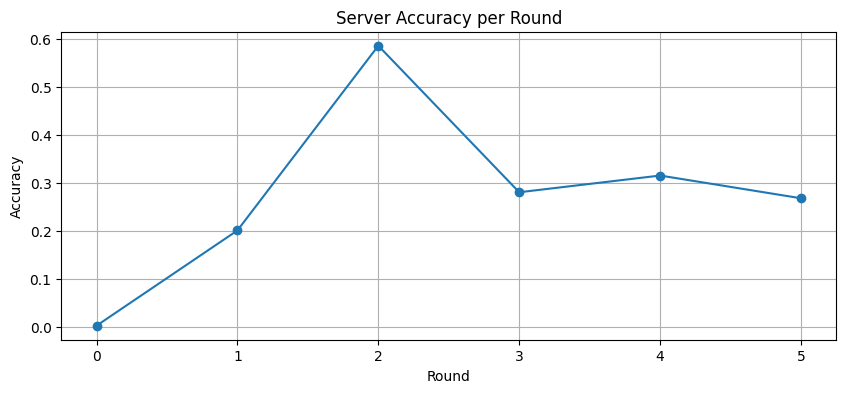

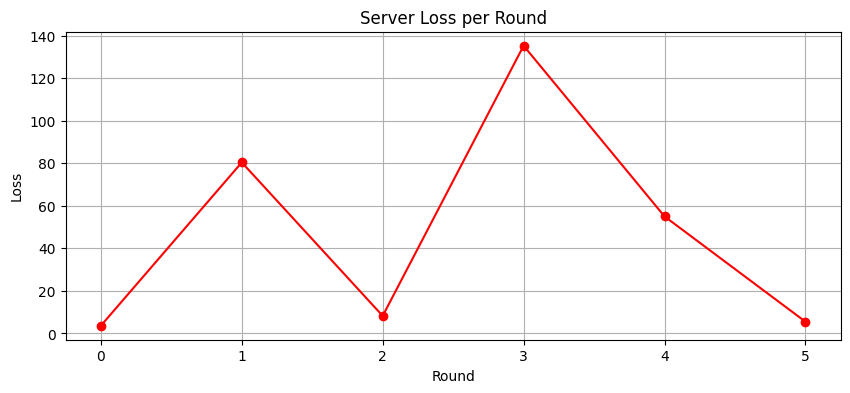

In [35]:
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# --- LOG START ---
print(f"{Colours.YELLOW.value}\nDeploy simulation... Method = {METHOD} - {class_size_map[num_unique_classes]} ({class_size}) Classifier")
print(f"Number of Clients = {NUM_OF_CLIENTS}\n")
print(f"Writing output to: {sub_dir_name}/{test_directory_name}\n{Colours.NORMAL.value}")

# Ghi thông tin ban đầu vào file
with open(f"Output/{sub_dir_name}/{test_directory_name}/Run_details.txt", "a") as f:
    f.write(f"{datetime.datetime.now()} - Deploy simulation... Method = {METHOD} - {class_size_map[num_unique_classes]} ({class_size}) Classifier\n")
    f.write(f"{datetime.datetime.now()} - Number of Clients = {NUM_OF_CLIENTS}\n")
    f.write(f"{datetime.datetime.now()} - Original train_df size: {train_df_shape}\n")

    for i in range(len(fl_X_train)):
        f.write(f"{datetime.datetime.now()} - {i}: X Shape {fl_X_train[i].shape}, Y Shape {fl_y_train[i].shape}\n")

    f.write(f"{datetime.datetime.now()} - X_test size: {X_test.shape}\n")
    f.write(f"{datetime.datetime.now()} - y_test size: {y_test.shape}\n")

# --- START SIMULATION ---
start_time = datetime.datetime.now()

ray_init_args = {"num_cpus": 2}

server_accuracy_history = []
server_loss_history = []

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_OF_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_OF_ROUNDS),
    strategy=strategy,
    client_resources={"num_cpus": 1},
    ray_init_args=ray_init_args,
)

end_time = datetime.datetime.now()
print("Total time taken: ", end_time - start_time)

# --- LOG END ---
print(f"{Colours.YELLOW.value}SIMULATION COMPLETE. Method = {METHOD} - {class_size_map[num_unique_classes]} ({class_size}) Classifier")
print(f"Number of Clients = {NUM_OF_CLIENTS}{Colours.NORMAL.value}\n")

# Ghi thông tin kết thúc vào file
with open(f"Output/{sub_dir_name}/{test_directory_name}/Run_details.txt", "a") as f:
    f.write(f"{datetime.datetime.now()} - SIMULATION COMPLETE. Method = {METHOD} - {class_size_map[num_unique_classes]} ({class_size}) Classifier\n")
    f.write(f"{datetime.datetime.now()} - Total time taken: {end_time - start_time}\n")

# --- PLOT ACCURACY ---
plt.figure(figsize=(10, 4))
plt.plot(server_accuracy_history, marker='o')
plt.title('Server Accuracy per Round')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.grid(True)
plt.savefig(f"Output/{sub_dir_name}/{test_directory_name}/server_accuracy_per_round.png")
plt.show()

# --- PLOT LOSS ---
plt.figure(figsize=(10, 4))
plt.plot(server_loss_history, marker='o', color='red')
plt.title('Server Loss per Round')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.grid(True)
plt.savefig(f"Output/{sub_dir_name}/{test_directory_name}/server_loss_per_round.png")
plt.show()
